In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [1]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

#             X = torch.cat((X,X,X),0)

        return X, y

NameError: name 'Dataset' is not defined

In [2]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

NameError: name 'pd' is not defined

### Baseline (4 blocks of VGG with bn)

In [10]:
class Baseline(nn.Module):
    def __init__(self, embeddings=False):
        
        super(Baseline, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
  
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = nn.Flatten()(x)
        x = self.classifier(x)
        
        return x

In [11]:
device = torch.device('cuda')
print(device)

model = Baseline()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [12]:
model = model.to(device)

model_path = './baseline_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3310329914093018 Batch_id=224  Accuracy=38.65: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]

- Avg.loss: 1.607  | Avg.acc: 0.387



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.443  | Avg. val_acc: 0.456
* Update optimal model
Epoch:  2


Loss=1.2239130735397339 Batch_id=224  Accuracy=49.11: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


- Avg.loss: 1.345  | Avg.acc: 0.491


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.289  | Avg. val_acc: 0.510
* Update optimal model
Epoch:  3


Loss=1.3561136722564697 Batch_id=224  Accuracy=51.38: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.277  | Avg.acc: 0.514



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.296  | Avg. val_acc: 0.489
Epoch:  4


Loss=1.284887671470642 Batch_id=224  Accuracy=53.29: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s] 

- Avg.loss: 1.229  | Avg.acc: 0.533



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214  | Avg. val_acc: 0.537
* Update optimal model
Epoch:  5


Loss=1.3612074851989746 Batch_id=224  Accuracy=54.11: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.203  | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.170  | Avg. val_acc: 0.558
* Update optimal model
Epoch:  6


Loss=1.134266972541809 Batch_id=224  Accuracy=54.97: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s] 

- Avg.loss: 1.179  | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.191  | Avg. val_acc: 0.545
Epoch:  7


Loss=1.0931081771850586 Batch_id=224  Accuracy=56.01: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]


- Avg.loss: 1.158  | Avg.acc: 0.560


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156  | Avg. val_acc: 0.556
Epoch:  8


Loss=1.2563666105270386 Batch_id=224  Accuracy=56.70: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.145  | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.153  | Avg. val_acc: 0.563
* Update optimal model
Epoch:  9


Loss=1.1629117727279663 Batch_id=224  Accuracy=57.27: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]

- Avg.loss: 1.129  | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.138  | Avg. val_acc: 0.574
* Update optimal model
Epoch:  10


Loss=1.0561546087265015 Batch_id=224  Accuracy=57.24: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.119  | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134  | Avg. val_acc: 0.567
Epoch:  11


Loss=0.932741641998291 Batch_id=224  Accuracy=57.82: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s] 

- Avg.loss: 1.115  | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157  | Avg. val_acc: 0.561
Epoch:  12


Loss=1.2030348777770996 Batch_id=224  Accuracy=58.14: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.100  | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116  | Avg. val_acc: 0.567
Epoch:  13


Loss=0.9866688847541809 Batch_id=224  Accuracy=58.55: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 1.094  | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130  | Avg. val_acc: 0.572
Epoch:  14


Loss=0.941982090473175 Batch_id=224  Accuracy=58.67: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s] 

- Avg.loss: 1.091  | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113  | Avg. val_acc: 0.576
* Update optimal model
Epoch:  15


Loss=1.1815532445907593 Batch_id=224  Accuracy=59.05: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.079  | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130  | Avg. val_acc: 0.579
* Update optimal model
Epoch:  16


Loss=0.9396145939826965 Batch_id=224  Accuracy=58.76: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 1.078  | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087  | Avg. val_acc: 0.590
* Update optimal model
Epoch:  17


Loss=0.744350254535675 Batch_id=224  Accuracy=59.15: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s] 

- Avg.loss: 1.080  | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.119  | Avg. val_acc: 0.583
Epoch:  18


Loss=0.9601671099662781 Batch_id=224  Accuracy=59.24: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.078  | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114  | Avg. val_acc: 0.585
Epoch:  19


Loss=1.0867365598678589 Batch_id=224  Accuracy=59.59: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


- Avg.loss: 1.063  | Avg.acc: 0.596


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102  | Avg. val_acc: 0.579
Epoch:  20


Loss=0.9681229591369629 Batch_id=224  Accuracy=59.73: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.062  | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096  | Avg. val_acc: 0.587
Epoch:  21


Loss=0.972771942615509 Batch_id=224  Accuracy=59.77: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s] 

- Avg.loss: 1.062  | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074  | Avg. val_acc: 0.596
* Update optimal model
Epoch:  22


Loss=0.9692283868789673 Batch_id=224  Accuracy=59.90: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 1.057  | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121  | Avg. val_acc: 0.575
Epoch:  23


Loss=0.9625683426856995 Batch_id=224  Accuracy=60.34: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 1.050  | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078  | Avg. val_acc: 0.601
* Update optimal model
Epoch:  24


Loss=1.3121631145477295 Batch_id=224  Accuracy=60.32: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 1.043  | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.595
Epoch:  25


Loss=1.2354563474655151 Batch_id=224  Accuracy=60.60: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 1.046  | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095  | Avg. val_acc: 0.590
Epoch:  26


Loss=1.0273127555847168 Batch_id=224  Accuracy=60.43: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.044  | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098  | Avg. val_acc: 0.599
Epoch:  27


Loss=1.1599750518798828 Batch_id=224  Accuracy=60.46: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]

- Avg.loss: 1.044  | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117  | Avg. val_acc: 0.584
Epoch:  28


Loss=1.108352780342102 Batch_id=224  Accuracy=60.52: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s] 

- Avg.loss: 1.036  | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083  | Avg. val_acc: 0.587
Epoch:  29


Loss=0.903448760509491 Batch_id=224  Accuracy=60.98: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s] 

- Avg.loss: 1.032  | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078  | Avg. val_acc: 0.600
Epoch:  30


Loss=1.3307876586914062 Batch_id=224  Accuracy=60.75: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 1.039  | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058  | Avg. val_acc: 0.609
* Update optimal model
Epoch:  31


Loss=1.2601083517074585 Batch_id=224  Accuracy=61.28: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 1.023  | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080  | Avg. val_acc: 0.603
Epoch:  32


Loss=1.2059500217437744 Batch_id=224  Accuracy=61.39: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.020  | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090  | Avg. val_acc: 0.587
Epoch:  33


Loss=1.0343159437179565 Batch_id=224  Accuracy=61.27: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 1.025  | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073  | Avg. val_acc: 0.598
Epoch:  34


Loss=0.9151248335838318 Batch_id=224  Accuracy=61.20: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 1.021  | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076  | Avg. val_acc: 0.600
Epoch:  35


Loss=1.0942974090576172 Batch_id=224  Accuracy=61.59: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 1.018  | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050  | Avg. val_acc: 0.608
Epoch:  36


Loss=1.156219244003296 Batch_id=224  Accuracy=61.51: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s] 

- Avg.loss: 1.017  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059  | Avg. val_acc: 0.603
Epoch:  37


Loss=1.179399847984314 Batch_id=224  Accuracy=61.40: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s] 

- Avg.loss: 1.017  | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080  | Avg. val_acc: 0.598
Epoch:  38


Loss=0.8474460244178772 Batch_id=224  Accuracy=61.74: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.017  | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043  | Avg. val_acc: 0.607
Epoch:  39


Loss=0.8026978373527527 Batch_id=224  Accuracy=61.93: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s]

- Avg.loss: 1.012  | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052  | Avg. val_acc: 0.609
* Update optimal model
Epoch:  40


Loss=0.9833229780197144 Batch_id=224  Accuracy=61.65: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 1.010  | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068  | Avg. val_acc: 0.605
Epoch:  41


Loss=1.1807258129119873 Batch_id=224  Accuracy=62.10: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 1.008  | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079  | Avg. val_acc: 0.606
Epoch:  42


Loss=0.8079442381858826 Batch_id=224  Accuracy=62.19: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.003  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103  | Avg. val_acc: 0.594
Epoch:  43


Loss=1.0360326766967773 Batch_id=224  Accuracy=62.22: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.000  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108  | Avg. val_acc: 0.577
Epoch:  44


Loss=1.0297738313674927 Batch_id=224  Accuracy=62.13: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.000  | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091  | Avg. val_acc: 0.592
Epoch:  45


Loss=1.1103936433792114 Batch_id=224  Accuracy=62.20: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 1.004  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052  | Avg. val_acc: 0.609
* Update optimal model
Epoch:  46


Loss=1.031461477279663 Batch_id=224  Accuracy=62.12: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s] 

- Avg.loss: 0.996  | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057  | Avg. val_acc: 0.602
Epoch:  47


Loss=1.1697793006896973 Batch_id=224  Accuracy=62.07: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


- Avg.loss: 0.997  | Avg.acc: 0.621


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073  | Avg. val_acc: 0.604
Epoch    47: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  48


Loss=1.104023814201355 Batch_id=224  Accuracy=64.35: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s] 

- Avg.loss: 0.951  | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039  | Avg. val_acc: 0.609
Epoch:  49


Loss=0.7579025030136108 Batch_id=224  Accuracy=64.89: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.929  | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018  | Avg. val_acc: 0.618
* Update optimal model
Epoch:  50


Loss=1.096550703048706 Batch_id=224  Accuracy=65.26: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s] 

- Avg.loss: 0.924  | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026  | Avg. val_acc: 0.615
Epoch:  51


Loss=0.8903239369392395 Batch_id=224  Accuracy=65.55: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]

- Avg.loss: 0.916  | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014  | Avg. val_acc: 0.629
* Update optimal model
Epoch:  52


Loss=1.006717562675476 Batch_id=224  Accuracy=65.71: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s] 

- Avg.loss: 0.914  | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033  | Avg. val_acc: 0.622
Epoch:  53


Loss=0.710237443447113 Batch_id=224  Accuracy=65.56: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s] 

- Avg.loss: 0.909  | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021  | Avg. val_acc: 0.626
Epoch:  54


Loss=0.8448026776313782 Batch_id=224  Accuracy=65.91: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.904  | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020  | Avg. val_acc: 0.627
Epoch:  55


Loss=0.5267999768257141 Batch_id=224  Accuracy=66.37: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 0.895  | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042  | Avg. val_acc: 0.617
Epoch:  56


Loss=0.9816461801528931 Batch_id=224  Accuracy=66.35: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.896  | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056  | Avg. val_acc: 0.607
Epoch:  57


Loss=1.1109143495559692 Batch_id=224  Accuracy=66.62: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.891  | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030  | Avg. val_acc: 0.619
Epoch:  58


Loss=0.9860268831253052 Batch_id=224  Accuracy=66.69: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.886  | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026  | Avg. val_acc: 0.631
* Update optimal model
Epoch:  59


Loss=0.8178582787513733 Batch_id=224  Accuracy=66.93: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.886  | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035  | Avg. val_acc: 0.624
Epoch:  60


Loss=1.2672185897827148 Batch_id=224  Accuracy=67.04: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.877  | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047  | Avg. val_acc: 0.614
Epoch    60: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  61


Loss=0.8757432699203491 Batch_id=224  Accuracy=68.05: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.846  | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023  | Avg. val_acc: 0.633
* Update optimal model
Epoch:  62


Loss=1.0956639051437378 Batch_id=224  Accuracy=69.22: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 0.824  | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035  | Avg. val_acc: 0.634
* Update optimal model
Epoch:  63


Loss=0.8031453490257263 Batch_id=224  Accuracy=69.49: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 0.818  | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028  | Avg. val_acc: 0.630
Epoch:  64


Loss=0.6524938941001892 Batch_id=224  Accuracy=69.81: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.810  | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031  | Avg. val_acc: 0.637
* Update optimal model
Epoch:  65


Loss=1.009189248085022 Batch_id=224  Accuracy=70.22: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s] 

- Avg.loss: 0.804  | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029  | Avg. val_acc: 0.633
Epoch:  66


Loss=0.7258749008178711 Batch_id=224  Accuracy=70.57: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.790  | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038  | Avg. val_acc: 0.636
Epoch:  67


Loss=1.0012221336364746 Batch_id=224  Accuracy=70.54: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]


- Avg.loss: 0.790  | Avg.acc: 0.705


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045  | Avg. val_acc: 0.634
Epoch:  68


Loss=0.915823221206665 Batch_id=224  Accuracy=70.34: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s] 

- Avg.loss: 0.790  | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037  | Avg. val_acc: 0.636
Epoch:  69


Loss=0.9165720343589783 Batch_id=224  Accuracy=70.59: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.788  | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061  | Avg. val_acc: 0.628
Epoch    69: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  70


Loss=0.8950037360191345 Batch_id=224  Accuracy=71.91: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.753  | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044  | Avg. val_acc: 0.635
Epoch:  71


Loss=0.8371865749359131 Batch_id=224  Accuracy=72.31: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.747  | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034  | Avg. val_acc: 0.638
* Update optimal model
Epoch:  72


Loss=0.8080320954322815 Batch_id=224  Accuracy=72.66: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.735  | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044  | Avg. val_acc: 0.640
* Update optimal model
Epoch:  73


Loss=0.6245922446250916 Batch_id=224  Accuracy=73.09: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.728  | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044  | Avg. val_acc: 0.639
Epoch:  74


Loss=0.7257570028305054 Batch_id=224  Accuracy=73.40: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.723  | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059  | Avg. val_acc: 0.633
Epoch:  75


Loss=0.7426491975784302 Batch_id=224  Accuracy=73.29: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]

- Avg.loss: 0.717  | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070  | Avg. val_acc: 0.640
Epoch:  76


Loss=0.8161176443099976 Batch_id=224  Accuracy=73.42: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.716  | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077  | Avg. val_acc: 0.636
Epoch:  77


Loss=0.43384677171707153 Batch_id=224  Accuracy=73.65: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.710  | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068  | Avg. val_acc: 0.635
Epoch:  78


Loss=1.2164503335952759 Batch_id=224  Accuracy=73.79: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.705  | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082  | Avg. val_acc: 0.636
Epoch    78: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  79


Loss=1.120244026184082 Batch_id=224  Accuracy=74.58: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]  

- Avg.loss: 0.690  | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068  | Avg. val_acc: 0.638
Epoch:  80


Loss=0.7389973998069763 Batch_id=224  Accuracy=74.65: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.684  | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066  | Avg. val_acc: 0.638
Epoch:  81


Loss=0.6063213348388672 Batch_id=224  Accuracy=74.54: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 0.684  | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057  | Avg. val_acc: 0.645
* Update optimal model
Epoch:  82


Loss=0.850424587726593 Batch_id=224  Accuracy=75.11: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s] 

- Avg.loss: 0.677  | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069  | Avg. val_acc: 0.639
Epoch:  83


Loss=0.5977754592895508 Batch_id=224  Accuracy=75.50: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s] 

- Avg.loss: 0.670  | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074  | Avg. val_acc: 0.639
Epoch:  84


Loss=0.7792158126831055 Batch_id=224  Accuracy=75.20: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.666  | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076  | Avg. val_acc: 0.639
Epoch:  85


Loss=0.7680326104164124 Batch_id=224  Accuracy=75.72: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s] 

- Avg.loss: 0.658  | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078  | Avg. val_acc: 0.641
Epoch:  86


Loss=0.7799224853515625 Batch_id=224  Accuracy=75.88: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s] 

- Avg.loss: 0.656  | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078  | Avg. val_acc: 0.637
Epoch:  87


Loss=0.6550419330596924 Batch_id=224  Accuracy=75.78: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.662  | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072  | Avg. val_acc: 0.643
Epoch    87: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  88


Loss=0.6007534265518188 Batch_id=224  Accuracy=76.21: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 0.647  | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080  | Avg. val_acc: 0.644
Epoch:  89


Loss=0.7504745125770569 Batch_id=224  Accuracy=76.33: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s] 

- Avg.loss: 0.644  | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084  | Avg. val_acc: 0.646
* Update optimal model
Epoch:  90


Loss=0.6948707699775696 Batch_id=224  Accuracy=75.97: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.647  | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089  | Avg. val_acc: 0.638
Epoch:  91


Loss=0.7619529366493225 Batch_id=224  Accuracy=76.53: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s] 

- Avg.loss: 0.641  | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074  | Avg. val_acc: 0.642
Epoch:  92


Loss=0.716535210609436 Batch_id=224  Accuracy=76.49: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]  

- Avg.loss: 0.640  | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083  | Avg. val_acc: 0.642
Epoch:  93


Loss=0.9168956875801086 Batch_id=224  Accuracy=76.60: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.640  | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087  | Avg. val_acc: 0.643
Epoch:  94


Loss=0.7350541353225708 Batch_id=224  Accuracy=76.58: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]

- Avg.loss: 0.639  | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079  | Avg. val_acc: 0.638
Epoch:  95


Loss=0.858664333820343 Batch_id=224  Accuracy=76.84: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]  

- Avg.loss: 0.634  | Avg.acc: 0.768



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084  | Avg. val_acc: 0.639
Epoch:  96


Loss=0.7768396139144897 Batch_id=224  Accuracy=76.70: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s] 


- Avg.loss: 0.637  | Avg.acc: 0.767


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099  | Avg. val_acc: 0.638
Epoch    96: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  97


Loss=0.5305739045143127 Batch_id=224  Accuracy=76.85: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 0.633  | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090  | Avg. val_acc: 0.640
Epoch:  98


Loss=0.91424959897995 Batch_id=224  Accuracy=76.94: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]   

- Avg.loss: 0.630  | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.642
Epoch:  99


Loss=0.7817293405532837 Batch_id=224  Accuracy=76.95: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.629  | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093  | Avg. val_acc: 0.644
Epoch:  100


Loss=0.6265630722045898 Batch_id=224  Accuracy=77.02: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.625  | Avg.acc: 0.770


- Avg. val_loss: 1.088  | Avg. val_acc: 0.641
Finished Training


([<matplotlib.lines.Line2D at 0x7fe99879fb70>,
 0.6464196154917804,
 1.0842781422961287)

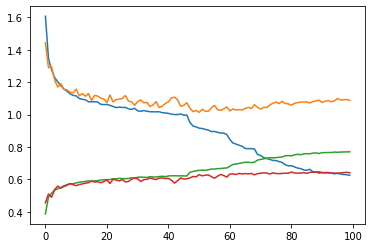

In [14]:
import pickle
pickle.dump(hist, open('./baseline_hist.hdf5', 'wb'))
plt.plot(hist), best_acc, curloss

In [16]:
# EVALUATE
model = torch.load('./baseline_model.pt')
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_preds = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc
    
    _preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
    _labels.append(labels.cpu().numpy())

_preds = np.concatenate(_preds)
_labels = np.concatenate(_labels)
print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.006  | Avg. val_acc: 0.654


Text(0.5, 1, 'baseline')

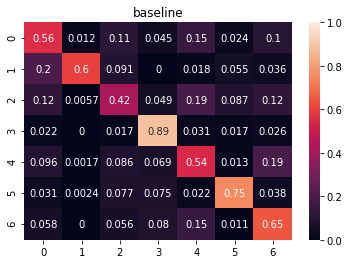

In [21]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

sn.heatmap(confusion_matrix(_labels, _preds, normalize='true'), annot=True, vmin=0, vmax=1)
plt.title('baseline')

## Add residual block

In [29]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), stride=1, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        
        return x

In [30]:
class ResidualBaseline(nn.Module):
    def __init__(self):
        
        super(ResidualBaseline, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
  
        
        self.residual_0_2 = ResidualBlock(32, 64)
        self.residual_1_3 = ResidualBlock(64, 128)
        self.residual_2_out = ResidualBlock(128, 256)
    
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                        nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                        nn.Linear(128, 7), nn.BatchNorm1d(7))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        
        x_0 = self.maxpool(x)
        
        x = self.conv1(x_0)
        x = self.bn1(x)
        
        #residual 0_2 before relu
        x0_2 = self.residual_0_2(x_0)
        x = x + x0_2
        
        x = self.relu(x)
        
        x_1 = self.maxpool(x)
        
        x = self.conv2(x_1)
        x = self.bn2(x)
        
        # residual 1_3 before relu
        x1_3 = self.residual_1_3(x_1)
        x = x + x1_3
        
        x = self.relu(x)
        
        x_2 = self.maxpool(x)
        
        x = self.conv3(x_2)
        x = self.bn3(x)
        
        # residual 2_out before relu
        x2_out = self.residual_2_out(x_2)
        x = x + x2_out
        
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = nn.Flatten()(x)
        x = self.classifier(x)
        
        return x

In [31]:
device = torch.device('cuda')
print(device)

model = ResidualBaseline()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [32]:
model = model.to(device)

model_path = './residual_baseline_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.441920280456543 Batch_id=224  Accuracy=40.72: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s] 

- Avg.loss: 1.578  | Avg.acc: 0.407



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.375  | Avg. val_acc: 0.481
* Update optimal model
Epoch:  2


Loss=1.4671913385391235 Batch_id=224  Accuracy=49.07: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.339  | Avg.acc: 0.491



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.306  | Avg. val_acc: 0.507
* Update optimal model
Epoch:  3


Loss=1.475764513015747 Batch_id=224  Accuracy=51.47: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s] 

- Avg.loss: 1.270  | Avg.acc: 0.515



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224  | Avg. val_acc: 0.535
* Update optimal model
Epoch:  4


Loss=1.2278136014938354 Batch_id=224  Accuracy=53.42: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 1.227  | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.193  | Avg. val_acc: 0.548
* Update optimal model
Epoch:  5


Loss=1.2859996557235718 Batch_id=224  Accuracy=54.49: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.199  | Avg.acc: 0.545



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139  | Avg. val_acc: 0.569
* Update optimal model
Epoch:  6


Loss=1.2751643657684326 Batch_id=224  Accuracy=55.02: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.179  | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195  | Avg. val_acc: 0.551
Epoch:  7


Loss=1.085686445236206 Batch_id=224  Accuracy=55.39: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s] 

- Avg.loss: 1.165  | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.189  | Avg. val_acc: 0.550
Epoch:  8


Loss=1.1447819471359253 Batch_id=224  Accuracy=56.15: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 1.146  | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162  | Avg. val_acc: 0.566
Epoch:  9


Loss=1.0499331951141357 Batch_id=224  Accuracy=57.44: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 1.134  | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150  | Avg. val_acc: 0.569
Epoch:  10


Loss=1.5068777799606323 Batch_id=224  Accuracy=57.24: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.126  | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175  | Avg. val_acc: 0.549
Epoch:  11


Loss=1.4380238056182861 Batch_id=224  Accuracy=57.61: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.121  | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.247  | Avg. val_acc: 0.539
Epoch:  12


Loss=1.247070074081421 Batch_id=224  Accuracy=57.80: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s] 

- Avg.loss: 1.110  | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.597
* Update optimal model
Epoch:  13


Loss=0.8522694110870361 Batch_id=224  Accuracy=58.24: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 1.106  | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.592
Epoch:  14


Loss=0.946479082107544 Batch_id=224  Accuracy=58.55: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s] 

- Avg.loss: 1.098  | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114  | Avg. val_acc: 0.585
Epoch:  15


Loss=0.9696754217147827 Batch_id=224  Accuracy=58.78: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 1.090  | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105  | Avg. val_acc: 0.595
Epoch:  16


Loss=0.979117214679718 Batch_id=224  Accuracy=58.47: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s] 

- Avg.loss: 1.095  | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.128  | Avg. val_acc: 0.572
Epoch:  17


Loss=1.457387924194336 Batch_id=224  Accuracy=59.05: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s] 

- Avg.loss: 1.083  | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.309  | Avg. val_acc: 0.511
Epoch:  18


Loss=0.8977498412132263 Batch_id=224  Accuracy=59.25: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.079  | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248  | Avg. val_acc: 0.538
Epoch:  19


Loss=1.4026578664779663 Batch_id=224  Accuracy=59.51: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 1.075  | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116  | Avg. val_acc: 0.588
Epoch:  20


Loss=1.1579716205596924 Batch_id=224  Accuracy=59.55: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.065  | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145  | Avg. val_acc: 0.569
Epoch:  21


Loss=1.0546551942825317 Batch_id=224  Accuracy=59.52: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 1.072  | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085  | Avg. val_acc: 0.595
Epoch:  22


Loss=0.964687168598175 Batch_id=224  Accuracy=59.70: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s] 

- Avg.loss: 1.063  | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081  | Avg. val_acc: 0.584
Epoch:  23


Loss=0.7884647846221924 Batch_id=224  Accuracy=59.94: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.056  | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076  | Avg. val_acc: 0.593
Epoch:  24


Loss=1.0029257535934448 Batch_id=224  Accuracy=60.11: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 1.057  | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093  | Avg. val_acc: 0.590
Epoch:  25


Loss=1.0140926837921143 Batch_id=224  Accuracy=59.94: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 1.059  | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079  | Avg. val_acc: 0.583
Epoch:  26


Loss=1.1835936307907104 Batch_id=224  Accuracy=60.06: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.052  | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069  | Avg. val_acc: 0.596
Epoch:  27


Loss=1.221045970916748 Batch_id=224  Accuracy=60.20: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s] 

- Avg.loss: 1.047  | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.584
Epoch:  28


Loss=1.169366717338562 Batch_id=224  Accuracy=60.38: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s] 

- Avg.loss: 1.046  | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073  | Avg. val_acc: 0.593
Epoch:  29


Loss=1.1361616849899292 Batch_id=224  Accuracy=60.64: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.041  | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147  | Avg. val_acc: 0.570
Epoch:  30


Loss=1.1658903360366821 Batch_id=224  Accuracy=60.88: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 1.040  | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066  | Avg. val_acc: 0.590
Epoch:  31


Loss=1.2126346826553345 Batch_id=224  Accuracy=60.63: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 1.044  | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090  | Avg. val_acc: 0.590
Epoch:  32


Loss=1.057583212852478 Batch_id=224  Accuracy=60.99: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s] 

- Avg.loss: 1.031  | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064  | Avg. val_acc: 0.605
* Update optimal model
Epoch:  33


Loss=1.1157833337783813 Batch_id=224  Accuracy=60.94: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]

- Avg.loss: 1.034  | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063  | Avg. val_acc: 0.604
Epoch:  34


Loss=1.1358239650726318 Batch_id=224  Accuracy=61.36: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 1.026  | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090  | Avg. val_acc: 0.591
Epoch:  35


Loss=1.0777158737182617 Batch_id=224  Accuracy=61.07: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 1.026  | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044  | Avg. val_acc: 0.612
* Update optimal model
Epoch:  36


Loss=0.7512478828430176 Batch_id=224  Accuracy=61.17: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 1.030  | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084  | Avg. val_acc: 0.590
Epoch:  37


Loss=0.9140414595603943 Batch_id=224  Accuracy=61.06: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 1.026  | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088  | Avg. val_acc: 0.594
Epoch:  38


Loss=1.1202898025512695 Batch_id=224  Accuracy=60.93: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 1.023  | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086  | Avg. val_acc: 0.596
Epoch:  39


Loss=0.9066619873046875 Batch_id=224  Accuracy=61.55: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 1.018  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118  | Avg. val_acc: 0.571
Epoch:  40


Loss=1.3137625455856323 Batch_id=224  Accuracy=61.87: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.014  | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088  | Avg. val_acc: 0.587
Epoch:  41


Loss=1.1419756412506104 Batch_id=224  Accuracy=60.97: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.021  | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071  | Avg. val_acc: 0.605
Epoch:  42


Loss=1.1686718463897705 Batch_id=224  Accuracy=61.12: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 1.021  | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080  | Avg. val_acc: 0.596
Epoch:  43


Loss=1.0429234504699707 Batch_id=224  Accuracy=61.50: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 1.014  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069  | Avg. val_acc: 0.603
Epoch:  44


Loss=1.2443838119506836 Batch_id=224  Accuracy=61.75: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 1.011  | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067  | Avg. val_acc: 0.590
Epoch    44: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  45


Loss=1.0555446147918701 Batch_id=224  Accuracy=63.92: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.957  | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010  | Avg. val_acc: 0.630
* Update optimal model
Epoch:  46


Loss=1.0564982891082764 Batch_id=224  Accuracy=64.78: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.936  | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030  | Avg. val_acc: 0.624
Epoch:  47


Loss=0.9529902338981628 Batch_id=224  Accuracy=65.03: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 0.931  | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028  | Avg. val_acc: 0.614
Epoch:  48


Loss=0.7995124459266663 Batch_id=224  Accuracy=65.07: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.928  | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028  | Avg. val_acc: 0.610
Epoch:  49


Loss=0.8530135154724121 Batch_id=224  Accuracy=65.47: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]

- Avg.loss: 0.918  | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027  | Avg. val_acc: 0.629
Epoch:  50


Loss=0.7524709701538086 Batch_id=224  Accuracy=65.80: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 0.909  | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006  | Avg. val_acc: 0.626
Epoch:  51


Loss=1.0049313306808472 Batch_id=224  Accuracy=66.04: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.909  | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040  | Avg. val_acc: 0.613
Epoch:  52


Loss=1.0613526105880737 Batch_id=224  Accuracy=65.47: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.912  | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031  | Avg. val_acc: 0.615
Epoch:  53


Loss=0.8491381406784058 Batch_id=224  Accuracy=66.15: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.907  | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022  | Avg. val_acc: 0.622
Epoch:  54


Loss=0.88556307554245 Batch_id=224  Accuracy=66.37: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]  

- Avg.loss: 0.899  | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033  | Avg. val_acc: 0.620
Epoch:  55


Loss=0.8300042152404785 Batch_id=224  Accuracy=66.47: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 0.890  | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027  | Avg. val_acc: 0.617
Epoch:  56


Loss=0.9110690951347351 Batch_id=224  Accuracy=66.72: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.889  | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026  | Avg. val_acc: 0.625
Epoch:  57


Loss=0.9326982498168945 Batch_id=224  Accuracy=66.51: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 0.884  | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046  | Avg. val_acc: 0.612
Epoch:  58


Loss=0.900343120098114 Batch_id=224  Accuracy=66.88: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s] 

- Avg.loss: 0.883  | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035  | Avg. val_acc: 0.615
Epoch:  59


Loss=0.8555593490600586 Batch_id=224  Accuracy=66.96: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.883  | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037  | Avg. val_acc: 0.626
Epoch    59: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  60


Loss=0.7192566394805908 Batch_id=224  Accuracy=68.09: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.842  | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007  | Avg. val_acc: 0.631
* Update optimal model
Epoch:  61


Loss=1.1381592750549316 Batch_id=224  Accuracy=69.03: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.824  | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016  | Avg. val_acc: 0.631
Epoch:  62


Loss=0.5392309427261353 Batch_id=224  Accuracy=70.00: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.809  | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007  | Avg. val_acc: 0.638
* Update optimal model
Epoch:  63


Loss=1.0658564567565918 Batch_id=224  Accuracy=69.85: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.807  | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018  | Avg. val_acc: 0.631
Epoch:  64


Loss=0.8536098003387451 Batch_id=224  Accuracy=70.15: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 0.802  | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011  | Avg. val_acc: 0.635
Epoch:  65


Loss=0.7495997548103333 Batch_id=224  Accuracy=70.35: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.793  | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029  | Avg. val_acc: 0.631
Epoch:  66


Loss=0.8762549161911011 Batch_id=224  Accuracy=70.87: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.782  | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020  | Avg. val_acc: 0.630
Epoch:  67


Loss=0.7651376724243164 Batch_id=224  Accuracy=70.76: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.782  | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016  | Avg. val_acc: 0.640
* Update optimal model
Epoch:  68


Loss=1.0592591762542725 Batch_id=224  Accuracy=70.77: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]


- Avg.loss: 0.783  | Avg.acc: 0.708


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034  | Avg. val_acc: 0.631
Epoch    68: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  69


Loss=0.6556270122528076 Batch_id=224  Accuracy=72.63: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.743  | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025  | Avg. val_acc: 0.643
* Update optimal model
Epoch:  70


Loss=0.616410493850708 Batch_id=224  Accuracy=72.30: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s] 

- Avg.loss: 0.739  | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024  | Avg. val_acc: 0.641
Epoch:  71


Loss=0.8128265738487244 Batch_id=224  Accuracy=73.12: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.728  | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033  | Avg. val_acc: 0.632
Epoch:  72


Loss=0.5109626054763794 Batch_id=224  Accuracy=73.49: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 0.714  | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040  | Avg. val_acc: 0.636
Epoch:  73


Loss=0.8734996914863586 Batch_id=224  Accuracy=73.73: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 0.714  | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054  | Avg. val_acc: 0.630
Epoch:  74


Loss=0.6427071690559387 Batch_id=224  Accuracy=73.83: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 0.708  | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067  | Avg. val_acc: 0.630
Epoch:  75


Loss=0.809517502784729 Batch_id=224  Accuracy=73.94: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s] 

- Avg.loss: 0.699  | Avg.acc: 0.739



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047  | Avg. val_acc: 0.636
Epoch:  76


Loss=0.7122272849082947 Batch_id=218  Accuracy=73.80:  96%|█████████▌| 216/225 [00:31<00:01,  6.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7fe90211e748>,
 0.6433546949010867,
 1.0772393556251005)

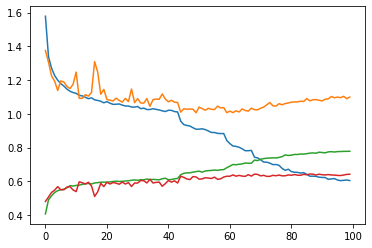

In [33]:
import pickle
pickle.dump(hist, open('./residual_baseline_hist.hdf5', 'wb'))
plt.plot(hist), best_acc, curloss

In [34]:
# EVALUATE
model = torch.load('./residual_baseline_model.pt')
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_preds = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc
    
    _preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
    _labels.append(labels.cpu().numpy())

_preds = np.concatenate(_preds)
_labels = np.concatenate(_labels)
print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.036  | Avg. val_acc: 0.649


Text(0.5, 1, 'baseline')

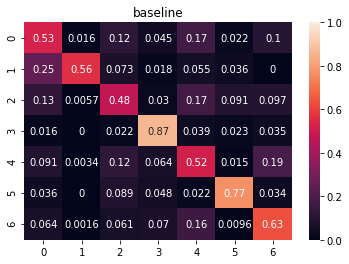

In [35]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

sn.heatmap(confusion_matrix(_labels, _preds, normalize='true'), annot=True, vmin=0, vmax=1)
plt.title('baseline')

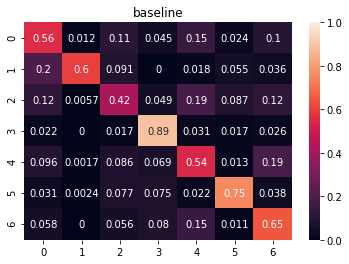

### Compare between baseline vs. residual baseline

In [2]:
import pickle
baseline_hist = pickle.load(open('./baseline_hist.hdf5', 'rb'))
residual_hist = pickle.load(open('./residual_baseline_hist.hdf5', 'rb'))

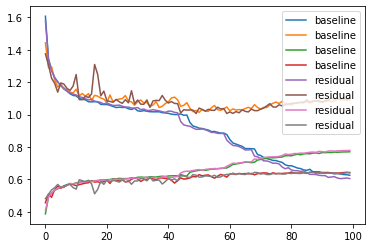

In [6]:
plt.plot(baseline_hist, label='baseline')
plt.plot(residual_hist, label='residual')

plt.legend()

plt.show()

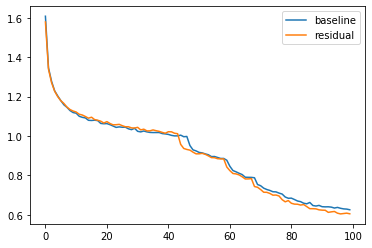

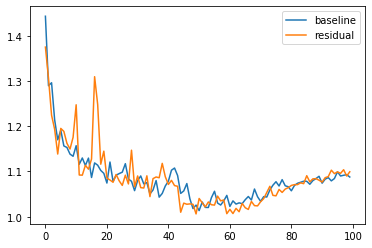

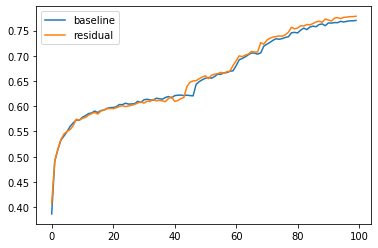

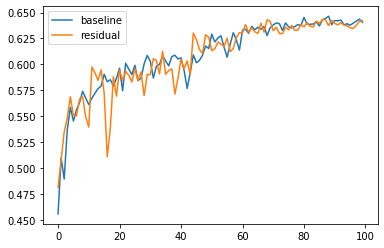

In [10]:
plt.plot([k[0] for k in baseline_hist], label='baseline')
plt.plot([k[0] for k in residual_hist], label='residual')
plt.legend()
plt.show()

plt.plot([k[1] for k in baseline_hist], label='baseline')
plt.plot([k[1] for k in residual_hist], label='residual')
plt.legend()
plt.show()

plt.plot([k[2] for k in baseline_hist], label='baseline')
plt.plot([k[2] for k in residual_hist], label='residual')
plt.legend()
plt.show()

plt.plot([k[3] for k in baseline_hist], label='baseline')
plt.plot([k[3] for k in residual_hist], label='residual')
plt.legend()
plt.show()

**Add residual does not significantly improve the baseline model**

### Feature Act 4

In [6]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.sm = nn.Softmax(dim=1)

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        # sm_cor = self.sm(cor)
        sm_cor = cor / torch.norm(cor)

        # with torch.no_grad():
        #   sm_cor += torch.randn(sm_cor.size()).to(device)

        cor_feature = torch.cat([(src_x * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)
        # cor_feature = self.sigmoid(cor_feature)

        # print('cor feature sigmoid: ', cor_feature)
        target_x = target_x * (1 + cor_feature)

        return target_x

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x = nn.Flatten()(xfact2_3)
        x = self.classifier(x)
        
        return x

In [8]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [9]:
model_path = './feature_act_4_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2931315898895264 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.757 | Avg.acc: 0.325



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.516 | Avg. val_acc: 0.401
* Update optimal model
Epoch:  2


Loss=0.8761873245239258 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.401 | Avg.acc: 0.463



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.318 | Avg. val_acc: 0.497
* Update optimal model
Epoch:  3


Loss=1.4969123601913452 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 1.300 | Avg.acc: 0.503



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.515
* Update optimal model
Epoch:  4


Loss=1.315882921218872 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.254 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.213 | Avg. val_acc: 0.536
* Update optimal model
Epoch:  5


Loss=1.3352665901184082 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.223 | Avg.acc: 0.536



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.212 | Avg. val_acc: 0.546
* Update optimal model
Epoch:  6


Loss=0.991359293460846 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.194 | Avg.acc: 0.546



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.508 | Avg. val_acc: 0.448
Epoch:  7


Loss=1.0742709636688232 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.182 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.198 | Avg. val_acc: 0.540
Epoch:  8


Loss=1.2082778215408325 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.163 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.207 | Avg. val_acc: 0.537
Epoch:  9


Loss=1.1781431436538696 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.151 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.574
* Update optimal model
Epoch:  10


Loss=0.942162275314331 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.138 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.567
Epoch:  11


Loss=1.1107535362243652 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.132 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.574
Epoch:  12


Loss=1.2470066547393799 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.126 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.170 | Avg. val_acc: 0.559
Epoch:  13


Loss=1.3225151300430298 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.115 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  14


Loss=1.226583480834961 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.101 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.566
Epoch:  15


Loss=1.082600474357605 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.101 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.569
Epoch:  16


Loss=1.0130138397216797 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.095 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117 | Avg. val_acc: 0.571
Epoch:  17


Loss=1.2883734703063965 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.088 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.577
Epoch:  18


Loss=1.125079870223999 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.092 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  19


Loss=1.0836447477340698 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.081 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.597
* Update optimal model
Epoch:  20


Loss=1.1598308086395264 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 1.071 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.577
Epoch:  21


Loss=1.009067177772522 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:01<00:00,  1.07s/it]

- Avg.loss: 1.070 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147 | Avg. val_acc: 0.567
Epoch:  22


Loss=1.1158053874969482 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.067 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.584
Epoch:  23


Loss=1.2122836112976074 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.062 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.588
Epoch:  24


Loss=1.24253511428833 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [04:42<00:00,  1.25s/it]

- Avg.loss: 1.061 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.579
Epoch:  25


Loss=1.1338149309158325 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 1.053 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.592
Epoch:  26


Loss=1.1006011962890625 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 1.053 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.603
* Update optimal model
Epoch:  27


Loss=1.1322470903396606 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.047 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.597
Epoch:  28


Loss=1.0098422765731812 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:44<00:00,  1.26s/it]

- Avg.loss: 1.046 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.194 | Avg. val_acc: 0.554
Epoch:  29


Loss=1.2913388013839722 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 1.049 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.591
Epoch:  30


Loss=0.9557656049728394 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.047 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  31


Loss=1.0721399784088135 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 1.038 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.606
Epoch:  32


Loss=1.4075675010681152 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [04:44<00:00,  1.26s/it]

- Avg.loss: 1.035 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.582
Epoch:  33


Loss=0.829906165599823 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.034 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.598
Epoch:  34


Loss=1.1454555988311768 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:42<00:00,  1.25s/it]

- Avg.loss: 1.032 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.569
Epoch:  35


Loss=1.167249083518982 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 1.030 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  36


Loss=0.9566797614097595 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.027 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.589
Epoch:  37


Loss=0.953572154045105 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.028 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.587
Epoch:  38


Loss=1.0802234411239624 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:44<00:00,  1.26s/it]

- Avg.loss: 1.028 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.599
Epoch:  39


Loss=1.2386178970336914 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 1.020 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.576
Epoch    39: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  40


Loss=0.8722658157348633 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.978 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  41


Loss=1.140014410018921 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.953 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.633
* Update optimal model
Epoch:  42


Loss=1.2218350172042847 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.947 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.613
Epoch:  43


Loss=0.9781440496444702 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.945 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.627
Epoch:  44


Loss=1.059743881225586 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 0.934 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.624
Epoch:  45


Loss=0.8090508580207825 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.940 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.630
Epoch:  46


Loss=1.1420551538467407 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.936 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.618
Epoch:  47


Loss=0.5765555500984192 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [04:44<00:00,  1.26s/it]

- Avg.loss: 0.931 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.629
Epoch:  48


Loss=1.0657613277435303 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.927 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.624
Epoch:  49


Loss=1.065299391746521 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:42<00:00,  1.25s/it]

- Avg.loss: 0.924 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.618
Epoch:  50


Loss=0.9628236293792725 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 0.917 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.625
Epoch:  51


Loss=1.0092285871505737 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.915 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.633
* Update optimal model
Epoch:  52


Loss=0.9381199479103088 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.910 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.628
Epoch:  53


Loss=0.9962590336799622 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 0.911 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  54


Loss=0.9428966641426086 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 0.907 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.621
Epoch:  55


Loss=0.7982408404350281 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.907 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.630
Epoch:  56


Loss=0.9574441909790039 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.909 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.630
Epoch:  57


Loss=0.9768335223197937 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.899 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.614
Epoch:  58


Loss=1.221024751663208 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 0.898 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  59


Loss=0.9674055576324463 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 0.901 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.626
Epoch:  60


Loss=0.9143274426460266 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:42<00:00,  1.25s/it]

- Avg.loss: 0.894 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.619
Epoch:  61


Loss=0.8094726204872131 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:42<00:00,  1.25s/it]

- Avg.loss: 0.896 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  62


Loss=0.732864260673523 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 0.887 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.631
Epoch:  63


Loss=0.8639413714408875 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.892 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.638
Epoch:  64


Loss=0.983220100402832 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 0.890 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.624
Epoch:  65


Loss=0.893012285232544 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 0.886 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.623
Epoch:  66


Loss=0.6514579653739929 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.886 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.622
Epoch:  67


Loss=0.7686263918876648 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.887 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.630
Epoch:  68


Loss=0.8459450006484985 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.886 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.616
Epoch:  69


Loss=0.9999908208847046 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it]

- Avg.loss: 0.879 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.618
Epoch:  70


Loss=1.0344425439834595 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:44<00:00,  1.26s/it]

- Avg.loss: 0.875 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.637
Epoch    70: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  71


Loss=0.8142313361167908 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.839 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.961 | Avg. val_acc: 0.645
* Update optimal model
Epoch:  72


Loss=0.819195568561554 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:44<00:00,  1.26s/it]

- Avg.loss: 0.823 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.968 | Avg. val_acc: 0.647
* Update optimal model
Epoch:  73


Loss=0.6441709995269775 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it]

- Avg.loss: 0.816 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.636
Epoch:  74


Loss=0.6743151545524597 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [04:44<00:00,  1.27s/it]

- Avg.loss: 0.814 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.650
* Update optimal model
Epoch:  75


Loss=0.8310681581497192 Batch_id=17 Accuracy=0.671875:   8%|▊         | 17/225 [00:25<04:28,  1.29s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9802833795547485 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:46<00:00,  1.27s/it]

- Avg.loss: 0.714 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.655
Epoch:  93


Loss=0.9460084438323975 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it]

- Avg.loss: 0.710 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.648
Epoch:  94


Loss=0.5060676336288452 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [04:46<00:00,  1.27s/it]

- Avg.loss: 0.706 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.657
* Update optimal model
Epoch:  95


Loss=0.7744366526603699 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:46<00:00,  1.27s/it]

- Avg.loss: 0.704 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.648
Epoch    95: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  96


Loss=0.9356545209884644 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it]

- Avg.loss: 0.684 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.656
Epoch:  97


Loss=0.9529097080230713 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:46<00:00,  1.27s/it]

- Avg.loss: 0.680 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.658
* Update optimal model
Epoch:  98


Loss=0.5367910265922546 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it]

- Avg.loss: 0.680 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.650
Epoch:  99


Loss=0.6560946106910706 Batch_id=130 Accuracy=0.75:  58%|█████▊    | 131/225 [02:48<01:58,  1.26s/it]     IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f3a20847780>,
 0.6584006687099471)

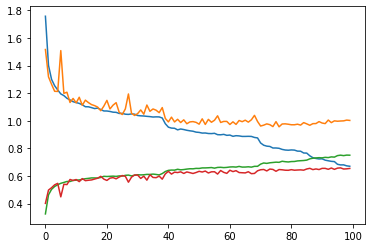

In [10]:
plt.plot(hist), best_acc

In [12]:
import pickle
pickle.dump(hist, open('./feature_act_4_hist.hdf5', 'wb'))

In [13]:
model = torch.load('./feature_act_4_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.977 | Avg. val_acc: 0.654


### Add triplet loss to feature act 4

In [11]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x_emb = nn.Flatten()(xfact2_3)
        x = self.classifier(x_emb)
        
        return x, x_emb

In [12]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [ ]:
model_path = './feature_act_4_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.0241177082061768 cep_loss=1.6350947618484497 triplet_loss=0.10765206068754196 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 1.170 | Avg.acc: 0.260



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.325
* Update optimal model
Epoch:  2


Loss=0.8949703574180603 cep_loss=1.4212414026260376 triplet_loss=0.1055637001991272 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.956 | Avg.acc: 0.411



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.946 | Avg. val_acc: 0.420
* Update optimal model
Epoch:  3


Loss=0.779234766960144 cep_loss=1.2321959733963013 triplet_loss=0.09979288280010223 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.866 | Avg.acc: 0.472



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.826 | Avg. val_acc: 0.501
* Update optimal model
Epoch:  4


Loss=0.8119660019874573 cep_loss=1.2815611362457275 triplet_loss=0.10757331550121307 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.822 | Avg.acc: 0.497



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.856 | Avg. val_acc: 0.488
Epoch:  5


Loss=0.7064670324325562 cep_loss=1.1090853214263916 triplet_loss=0.10253950208425522 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.799 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.806 | Avg. val_acc: 0.511
* Update optimal model
Epoch:  6


Loss=0.7599979043006897 cep_loss=1.1954759359359741 triplet_loss=0.10678089410066605 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.782 | Avg.acc: 0.531



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.770 | Avg. val_acc: 0.545
* Update optimal model
Epoch:  7


Loss=1.0885275602340698 cep_loss=1.744288682937622 triplet_loss=0.10488555580377579 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.768 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.773 | Avg. val_acc: 0.537
Epoch:  8


Loss=0.7272830009460449 cep_loss=1.1493947505950928 triplet_loss=0.09411528706550598 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.754 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.729 | Avg. val_acc: 0.584
* Update optimal model
Epoch:  9


Loss=0.6855152249336243 cep_loss=1.0721813440322876 triplet_loss=0.10551606863737106 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.747 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.734 | Avg. val_acc: 0.557
Epoch:  10


Loss=0.5950343608856201 cep_loss=0.9267801642417908 triplet_loss=0.09741566330194473 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.740 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.816 | Avg. val_acc: 0.517
Epoch:  11


Loss=0.8114892840385437 cep_loss=1.280215859413147 triplet_loss=0.10839934647083282 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.733 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.705 | Avg. val_acc: 0.577
Epoch:  12


Loss=0.8575230836868286 cep_loss=1.3640929460525513 triplet_loss=0.09766817092895508 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.724 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.743 | Avg. val_acc: 0.549
Epoch:  13


Loss=0.7974314093589783 cep_loss=1.2624492645263672 triplet_loss=0.0999046042561531 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.723 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.750 | Avg. val_acc: 0.553
Epoch:  14


Loss=0.7942783832550049 cep_loss=1.2538936138153076 triplet_loss=0.10485542565584183 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.719 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.741 | Avg. val_acc: 0.558
Epoch:  15


Loss=0.6421871185302734 cep_loss=1.002638816833496 triplet_loss=0.10150948911905289 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.712 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.752 | Avg. val_acc: 0.542
Epoch:  16


Loss=0.9246572852134705 cep_loss=1.466328740119934 triplet_loss=0.11215006560087204 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.707 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.728 | Avg. val_acc: 0.565
Epoch:  17


Loss=0.7266455292701721 cep_loss=1.1487599611282349 triplet_loss=0.09347385168075562 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.707 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.757 | Avg. val_acc: 0.544
Epoch:  18


Loss=0.7012729048728943 cep_loss=1.1023616790771484 triplet_loss=0.09963970631361008 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.703 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.830 | Avg. val_acc: 0.502
Epoch:  19


Loss=0.6677895784378052 cep_loss=1.050736904144287 triplet_loss=0.09336861222982407 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.703 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.715 | Avg. val_acc: 0.577
Epoch:  20


Loss=0.7994022369384766 cep_loss=1.2661880254745483 triplet_loss=0.09922336041927338 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.700 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.688 | Avg. val_acc: 0.597
* Update optimal model
Epoch:  21


Loss=0.7375549077987671 cep_loss=1.1611794233322144 triplet_loss=0.10211808979511261 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.698 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.702 | Avg. val_acc: 0.580
Epoch:  22


Loss=0.7953814268112183 cep_loss=1.2590789794921875 triplet_loss=0.09983500838279724 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.695 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.694 | Avg. val_acc: 0.593
Epoch:  23


Loss=0.6172987818717957 cep_loss=0.9597712159156799 triplet_loss=0.10359007120132446 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.691 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.711 | Avg. val_acc: 0.577
Epoch:  24


Loss=0.961883544921875 cep_loss=1.53261137008667 triplet_loss=0.10579168051481247 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.690 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.692 | Avg. val_acc: 0.590
Epoch:  25


Loss=0.7397965788841248 cep_loss=1.1697951555252075 triplet_loss=0.09479866921901703 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.687 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.699 | Avg. val_acc: 0.591
Epoch:  26


Loss=0.6325526237487793 cep_loss=0.9869213700294495 triplet_loss=0.10099944472312927 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.688 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.707 | Avg. val_acc: 0.579
Epoch:  27


Loss=0.7747198343276978 cep_loss=1.216299295425415 triplet_loss=0.11235051602125168 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:19<00:00,  2.84it/s]

- Avg.loss: 0.685 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.694 | Avg. val_acc: 0.585
Epoch:  28


Loss=0.8324901461601257 cep_loss=1.317564606666565 triplet_loss=0.10487835854291916 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.683 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.712 | Avg. val_acc: 0.583
Epoch:  29


Loss=0.5901346802711487 cep_loss=0.9203962087631226 triplet_loss=0.09474234282970428 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.683 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.692 | Avg. val_acc: 0.599
Epoch    29: reducing learning rate of group 0 to 2.0000e-03.
* Update optimal model
Epoch:  30


Loss=0.5431367754936218 cep_loss=0.84239661693573 triplet_loss=0.09424703568220139 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.651 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.662 | Avg. val_acc: 0.619
* Update optimal model
Epoch:  31


Loss=0.8265172839164734 cep_loss=1.3107678890228271 triplet_loss=0.10014133155345917 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.642 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.651 | Avg. val_acc: 0.619
Epoch:  32


Loss=0.7330859899520874 cep_loss=1.1591397523880005 triplet_loss=0.09400534629821777 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 0.641 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.658 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  33


Loss=0.7153826951980591 cep_loss=1.1244325637817383 triplet_loss=0.1018078401684761 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.638 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.659 | Avg. val_acc: 0.621
Epoch:  34


Loss=0.7564043402671814 cep_loss=1.1875625848770142 triplet_loss=0.1096668541431427 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.84it/s]

- Avg.loss: 0.634 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.652 | Avg. val_acc: 0.617
Epoch:  35


Loss=0.7834132313728333 cep_loss=1.2359955310821533 triplet_loss=0.10453971475362778 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.635 | Avg.acc: 0.629



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.654 | Avg. val_acc: 0.621
Epoch:  36


Loss=0.7741239070892334 cep_loss=1.2237387895584106 triplet_loss=0.09970153123140335 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.625 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.645 | Avg. val_acc: 0.618
Epoch:  37


Loss=0.6664842963218689 cep_loss=1.044022798538208 triplet_loss=0.10017649829387665 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.630 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.654 | Avg. val_acc: 0.624
Epoch:  38


Loss=0.6956653594970703 cep_loss=1.0879179239273071 triplet_loss=0.10728643834590912 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.626 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.669 | Avg. val_acc: 0.610
Epoch:  39


Loss=0.6233215928077698 cep_loss=0.9714105725288391 triplet_loss=0.10118810087442398 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.623 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.667 | Avg. val_acc: 0.609
Epoch:  40


Loss=0.7645373940467834 cep_loss=1.2002992630004883 triplet_loss=0.11089460551738739 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.622 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.657 | Avg. val_acc: 0.614
Epoch:  41


Loss=0.7530913352966309 cep_loss=1.1867656707763672 triplet_loss=0.10257981717586517 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.620 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.649 | Avg. val_acc: 0.620
Epoch:  42


Loss=0.6629229784011841 cep_loss=1.0376609563827515 triplet_loss=0.10081581771373749 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.84it/s]

- Avg.loss: 0.618 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.652 | Avg. val_acc: 0.620
Epoch:  43


Loss=0.6912574768066406 cep_loss=1.0839475393295288 triplet_loss=0.10222220420837402 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.617 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.649 | Avg. val_acc: 0.621
Epoch:  44


Loss=0.526128351688385 cep_loss=0.8127607107162476 triplet_loss=0.09617971628904343 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.617 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.662 | Avg. val_acc: 0.610
Epoch:  45


Loss=0.6109451651573181 cep_loss=0.9523487687110901 triplet_loss=0.098839670419693 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.615 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.651 | Avg. val_acc: 0.623
Epoch    45: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  46


Loss=0.693985104560852 cep_loss=1.095505952835083 triplet_loss=0.09170375764369965 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.590 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.623 | Avg. val_acc: 0.634
* Update optimal model
Epoch:  47


Loss=0.5869736671447754 cep_loss=0.9060958623886108 triplet_loss=0.10829024016857147 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.582 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.631 | Avg. val_acc: 0.637
* Update optimal model
Epoch:  48


Loss=0.6150178909301758 cep_loss=0.9626521468162537 triplet_loss=0.09356652200222015 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:19<00:00,  2.85it/s]

- Avg.loss: 0.580 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.624 | Avg. val_acc: 0.644
* Update optimal model
Epoch:  49


Loss=0.7537047863006592 cep_loss=1.1874679327011108 triplet_loss=0.1030600294470787 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.577 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.628 | Avg. val_acc: 0.637
Epoch:  50


Loss=0.42695334553718567 cep_loss=0.636161208152771 triplet_loss=0.11314152181148529 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 0.570 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.622 | Avg. val_acc: 0.640
Epoch:  51


Loss=0.4933917820453644 cep_loss=0.7595575451850891 triplet_loss=0.09414304792881012 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 0.572 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.633 | Avg. val_acc: 0.630
Epoch:  52


Loss=0.5843924283981323 cep_loss=0.9020826816558838 triplet_loss=0.10785693675279617 Batch_id=61 Accuracy=0.6484375:  27%|██▋       | 61/225 [00:23<00:56,  2.90it/s]

([<matplotlib.lines.Line2D at 0x7fb260d3c748>,
 0.6628587350236835)

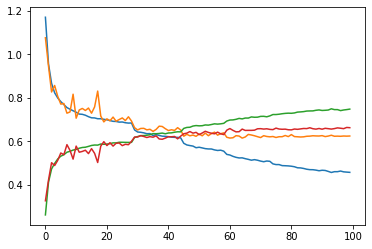

In [16]:
plt.plot(hist), best_acc

In [18]:
import pickle
pickle.dump(hist, open('feature_act_4_tripletloss_hist.hdf5', 'wb'))

In [21]:
model = torch.load('./feature_act_4_tripletloss_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, embeddings = model(inputs)
    indices_tuple = mining_func(embeddings, labels)
    triplet_loss = loss_func(embeddings, labels, indices_tuple)
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    all_loss = (0.6*loss) + (0.4*triplet_loss)

    running_valloss += (all_loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.621 | Avg. val_acc: 0.657


### Feature Act 5 with triplet loss for last conv feature and add conv. for src feature

In [20]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
        src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_feature * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)

        target_x = target_x * (1 + cor_feature)

        return target_x

In [21]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x_emb = nn.Flatten()(xfact2_3)
        x = self.classifier(x_emb)
        
        return x, x_emb

In [22]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [23]:
model_path = './feature_act_5_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.1105904579162598 cep_loss=1.7768237590789795 triplet_loss=0.11124037951231003 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 1.153 | Avg.acc: 0.270



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.321
* Update optimal model
Epoch:  2


Loss=0.794282078742981 cep_loss=1.257590889930725 triplet_loss=0.09931869804859161 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.949 | Avg.acc: 0.412



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.901 | Avg. val_acc: 0.454
* Update optimal model
Epoch:  3


Loss=0.8001315593719482 cep_loss=1.2619550228118896 triplet_loss=0.1073962152004242 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.854 | Avg.acc: 0.480



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.822 | Avg. val_acc: 0.499
* Update optimal model
Epoch:  4


Loss=0.7755630016326904 cep_loss=1.2269585132598877 triplet_loss=0.09846968948841095 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.818 | Avg.acc: 0.505



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.832 | Avg. val_acc: 0.497
Epoch:  5


Loss=0.8093414902687073 cep_loss=1.2821310758590698 triplet_loss=0.1001570075750351 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.795 | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.769 | Avg. val_acc: 0.540
* Update optimal model
Epoch:  6


Loss=0.9313787221908569 cep_loss=1.4823648929595947 triplet_loss=0.10489946603775024 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.776 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.914 | Avg. val_acc: 0.472
Epoch:  7


Loss=0.7765704393386841 cep_loss=1.2227528095245361 triplet_loss=0.10729684680700302 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.762 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.777 | Avg. val_acc: 0.540
Epoch:  8


Loss=0.9295525550842285 cep_loss=1.4806137084960938 triplet_loss=0.10296080261468887 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.754 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.779 | Avg. val_acc: 0.537
Epoch:  9


Loss=0.7586302757263184 cep_loss=1.1991345882415771 triplet_loss=0.09787384420633316 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.743 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.750 | Avg. val_acc: 0.561
* Update optimal model
Epoch:  10


Loss=0.7520928978919983 cep_loss=1.185232400894165 triplet_loss=0.10238362103700638 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.739 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.743 | Avg. val_acc: 0.556
Epoch:  11


Loss=0.6321537494659424 cep_loss=0.9874395132064819 triplet_loss=0.09922503679990768 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.730 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.747 | Avg. val_acc: 0.563
* Update optimal model
Epoch:  12


Loss=0.6691948771476746 cep_loss=1.0467437505722046 triplet_loss=0.10287145525217056 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.725 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.734 | Avg. val_acc: 0.545
Epoch:  13


Loss=0.6916415691375732 cep_loss=1.0920826196670532 triplet_loss=0.09097998589277267 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.721 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.712 | Avg. val_acc: 0.570
* Update optimal model
Epoch:  14


Loss=0.8392302393913269 cep_loss=1.329537034034729 triplet_loss=0.10376988351345062 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.716 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.725 | Avg. val_acc: 0.573
* Update optimal model
Epoch:  15


Loss=0.6565514206886292 cep_loss=1.027639627456665 triplet_loss=0.09991897642612457 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.713 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.726 | Avg. val_acc: 0.577
* Update optimal model
Epoch:  16


Loss=0.8415223956108093 cep_loss=1.3367919921875 triplet_loss=0.0986180379986763 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.706 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.688 | Avg. val_acc: 0.591
* Update optimal model
Epoch:  17


Loss=0.6959819793701172 cep_loss=1.092329502105713 triplet_loss=0.10146059840917587 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.706 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.700 | Avg. val_acc: 0.583
Epoch:  18


Loss=0.7512154579162598 cep_loss=1.1846461296081543 triplet_loss=0.10106942057609558 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.703 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.718 | Avg. val_acc: 0.569
Epoch:  19


Loss=0.734070897102356 cep_loss=1.1554172039031982 triplet_loss=0.10205133259296417 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.699 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.691 | Avg. val_acc: 0.596
* Update optimal model
Epoch:  20


Loss=0.7167643308639526 cep_loss=1.1307188272476196 triplet_loss=0.09583257138729095 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.698 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.706 | Avg. val_acc: 0.581
Epoch:  21


Loss=0.5395284295082092 cep_loss=0.836715817451477 triplet_loss=0.09374722838401794 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.694 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.686 | Avg. val_acc: 0.589
Epoch:  22


Loss=0.8349258899688721 cep_loss=1.3257873058319092 triplet_loss=0.09863366931676865 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.694 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.707 | Avg. val_acc: 0.575
Epoch:  23


Loss=0.8012440204620361 cep_loss=1.2662508487701416 triplet_loss=0.10373369604349136 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.691 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.710 | Avg. val_acc: 0.573
Epoch:  24


Loss=0.7511762976646423 cep_loss=1.1832271814346313 triplet_loss=0.1031000018119812 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.685 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.708 | Avg. val_acc: 0.586
Epoch:  25


Loss=0.8875135183334351 cep_loss=1.4110956192016602 triplet_loss=0.10214032232761383 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.685 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.695 | Avg. val_acc: 0.595
Epoch:  26


Loss=0.5943092107772827 cep_loss=0.927697479724884 triplet_loss=0.09422679245471954 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.684 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.724 | Avg. val_acc: 0.577
Epoch:  27


Loss=0.810483455657959 cep_loss=1.2834430932998657 triplet_loss=0.10104383528232574 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.687 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.693 | Avg. val_acc: 0.593
Epoch:  28


Loss=0.7798317074775696 cep_loss=1.2333006858825684 triplet_loss=0.09962806105613708 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.679 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.682 | Avg. val_acc: 0.593
Epoch:  29


Loss=0.6894010901451111 cep_loss=1.0817468166351318 triplet_loss=0.10088251531124115 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.684 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.698 | Avg. val_acc: 0.583
Epoch:  30


Loss=0.6259458661079407 cep_loss=0.9801164865493774 triplet_loss=0.09468987584114075 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.678 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.703 | Avg. val_acc: 0.579
Epoch:  31


Loss=0.8045145869255066 cep_loss=1.2707500457763672 triplet_loss=0.10516142845153809 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.677 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.684 | Avg. val_acc: 0.598
* Update optimal model
Epoch:  32


Loss=0.7271807193756104 cep_loss=1.1492846012115479 triplet_loss=0.09402482211589813 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.676 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.713 | Avg. val_acc: 0.568
Epoch:  33


Loss=0.6575990319252014 cep_loss=1.031111478805542 triplet_loss=0.09733035415410995 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.675 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.714 | Avg. val_acc: 0.581
Epoch:  34


Loss=0.6613481640815735 cep_loss=1.035109281539917 triplet_loss=0.1007063016295433 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.675 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.690 | Avg. val_acc: 0.601
* Update optimal model
Epoch:  35


Loss=0.8121402859687805 cep_loss=1.2866296768188477 triplet_loss=0.10040607303380966 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.674 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.688 | Avg. val_acc: 0.599
Epoch:  36


Loss=0.5670303106307983 cep_loss=0.8786910772323608 triplet_loss=0.09953921288251877 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.674 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.695 | Avg. val_acc: 0.598
Epoch    36: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  37


Loss=0.6900030374526978 cep_loss=1.0822913646697998 triplet_loss=0.10157043486833572 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.643 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.647 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  38


Loss=0.6355493068695068 cep_loss=0.9965947270393372 triplet_loss=0.09398114681243896 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.635 | Avg.acc: 0.629



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.667 | Avg. val_acc: 0.615
Epoch:  39


Loss=0.43962520360946655 cep_loss=0.6701160073280334 triplet_loss=0.09388893842697144 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.633 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.645 | Avg. val_acc: 0.624
* Update optimal model
Epoch:  40


Loss=0.7736815810203552 cep_loss=1.220699667930603 triplet_loss=0.10315439850091934 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.627 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.668 | Avg. val_acc: 0.610
Epoch:  41


Loss=0.84190833568573 cep_loss=1.3360856771469116 triplet_loss=0.10064221918582916 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.626 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.656 | Avg. val_acc: 0.621
Epoch:  42


Loss=0.6593036651611328 cep_loss=1.0315663814544678 triplet_loss=0.10090949386358261 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.620 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.647 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  43


Loss=0.5988428592681885 cep_loss=0.9286821484565735 triplet_loss=0.10408380627632141 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.621 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.647 | Avg. val_acc: 0.621
Epoch:  44


Loss=0.619547963142395 cep_loss=0.9667454361915588 triplet_loss=0.09875157475471497 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.619 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.657 | Avg. val_acc: 0.618
Epoch:  45


Loss=0.5903976559638977 cep_loss=0.9181610345840454 triplet_loss=0.0987524688243866 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.618 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.646 | Avg. val_acc: 0.625
Epoch:  46


Loss=0.602895200252533 cep_loss=0.9379498362541199 triplet_loss=0.10031306743621826 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.613 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.682 | Avg. val_acc: 0.607
Epoch:  47


Loss=0.6281325221061707 cep_loss=0.9818814992904663 triplet_loss=0.0975089967250824 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.618 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.642 | Avg. val_acc: 0.618
Epoch:  48


Loss=0.5432122349739075 cep_loss=0.842067539691925 triplet_loss=0.09492924064397812 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.614 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.659 | Avg. val_acc: 0.610
Epoch:  49


Loss=0.7189794778823853 cep_loss=1.1359847784042358 triplet_loss=0.09347142279148102 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.611 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.623
Epoch:  50


Loss=0.45382750034332275 cep_loss=0.6936845779418945 triplet_loss=0.0940418615937233 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.614 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.637 | Avg. val_acc: 0.619
Epoch:  51


Loss=0.46340131759643555 cep_loss=0.7096738219261169 triplet_loss=0.09399250149726868 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.607 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.640 | Avg. val_acc: 0.626
Epoch:  52


Loss=0.5555406212806702 cep_loss=0.8639670610427856 triplet_loss=0.09290081262588501 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.607 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.632 | Avg. val_acc: 0.634
* Update optimal model
Epoch:  53


Loss=0.5834019780158997 cep_loss=0.9070069789886475 triplet_loss=0.09799440205097198 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.605 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.627
Epoch:  54


Loss=0.6424543261528015 cep_loss=1.0021125078201294 triplet_loss=0.10296699404716492 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.607 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.652 | Avg. val_acc: 0.622
Epoch:  55


Loss=0.5240252017974854 cep_loss=0.8097963333129883 triplet_loss=0.09536842256784439 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.604 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.658 | Avg. val_acc: 0.616
Epoch:  56


Loss=0.6006680727005005 cep_loss=0.9370633959770203 triplet_loss=0.09607504308223724 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.604 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.658 | Avg. val_acc: 0.619
Epoch:  57


Loss=0.7272672653198242 cep_loss=1.1453120708465576 triplet_loss=0.10019998997449875 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.602 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.626
Epoch:  58


Loss=0.6734715104103088 cep_loss=1.0520685911178589 triplet_loss=0.10557573288679123 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.603 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.655 | Avg. val_acc: 0.630
Epoch:  59


Loss=0.5093583464622498 cep_loss=0.7831176519393921 triplet_loss=0.09871936589479446 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.600 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.672 | Avg. val_acc: 0.621
Epoch:  60


Loss=0.5290488600730896 cep_loss=0.8140173554420471 triplet_loss=0.10159599035978317 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.599 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.645 | Avg. val_acc: 0.627
Epoch    60: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  61


Loss=0.43959084153175354 cep_loss=0.6716029644012451 triplet_loss=0.09157265722751617 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.575 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.633 | Avg. val_acc: 0.637
* Update optimal model
Epoch:  62


Loss=0.6172407865524292 cep_loss=0.9614654779434204 triplet_loss=0.1009037047624588 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.569 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.627 | Avg. val_acc: 0.643
* Update optimal model
Epoch:  63


Loss=0.6757479310035706 cep_loss=1.0584919452667236 triplet_loss=0.10163185745477676 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.564 | Avg.acc: 0.675



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.624 | Avg. val_acc: 0.639
Epoch:  64


Loss=0.5648433566093445 cep_loss=0.8762158751487732 triplet_loss=0.09778459370136261 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.562 | Avg.acc: 0.675



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.640 | Avg. val_acc: 0.642
Epoch:  65


Loss=0.7123867869377136 cep_loss=1.1206592321395874 triplet_loss=0.09997793287038803 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.557 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.621 | Avg. val_acc: 0.649
* Update optimal model
Epoch:  66


Loss=0.56596839427948 cep_loss=0.8730794787406921 triplet_loss=0.10530178993940353 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.559 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.630 | Avg. val_acc: 0.632
Epoch:  67


Loss=0.5930407643318176 cep_loss=0.9242545366287231 triplet_loss=0.09622009098529816 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.553 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.635 | Avg. val_acc: 0.638
Epoch:  68


Loss=0.5942978858947754 cep_loss=0.9218440651893616 triplet_loss=0.10297854244709015 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.557 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.630 | Avg. val_acc: 0.645
Epoch:  69


Loss=0.537388265132904 cep_loss=0.8313025236129761 triplet_loss=0.09651681035757065 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.551 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.629 | Avg. val_acc: 0.644
Epoch:  70


Loss=0.5991831421852112 cep_loss=0.9337642788887024 triplet_loss=0.09731145203113556 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.552 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.625 | Avg. val_acc: 0.638
Epoch:  71


Loss=0.697939932346344 cep_loss=1.0911853313446045 triplet_loss=0.10807173699140549 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.547 | Avg.acc: 0.689



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.634 | Avg. val_acc: 0.649
* Update optimal model
Epoch:  72


Loss=0.43065622448921204 cep_loss=0.6584326028823853 triplet_loss=0.08899162709712982 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.545 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.632 | Avg. val_acc: 0.646
Epoch:  73


Loss=0.8377260565757751 cep_loss=1.322572112083435 triplet_loss=0.1104569062590599 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.547 | Avg.acc: 0.689



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.634
Epoch    73: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  74


Loss=0.5607748031616211 cep_loss=0.8720774054527283 triplet_loss=0.09382082521915436 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.530 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.621 | Avg. val_acc: 0.647
Epoch:  75


Loss=0.4930161237716675 cep_loss=0.7517276406288147 triplet_loss=0.10494876652956009 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.524 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.622 | Avg. val_acc: 0.649
* Update optimal model
Epoch:  76


Loss=0.4490070343017578 cep_loss=0.6838634014129639 triplet_loss=0.09672246128320694 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.521 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.642
Epoch:  77


Loss=0.532454252243042 cep_loss=0.8189569711685181 triplet_loss=0.10270015150308609 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.520 | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.617 | Avg. val_acc: 0.652
* Update optimal model
Epoch:  78


Loss=0.5166974067687988 cep_loss=0.7999458312988281 triplet_loss=0.09182475507259369 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 0.515 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.648
Epoch:  79


Loss=0.5127444267272949 cep_loss=0.7857809066772461 triplet_loss=0.10318967700004578 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.514 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.624 | Avg. val_acc: 0.651
Epoch:  80


Loss=0.4875926375389099 cep_loss=0.7528249621391296 triplet_loss=0.08974413573741913 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.510 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.617 | Avg. val_acc: 0.652
* Update optimal model
Epoch:  81


Loss=0.5687229037284851 cep_loss=0.8809488415718079 triplet_loss=0.10038390010595322 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.508 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.622 | Avg. val_acc: 0.645
Epoch:  82


Loss=0.49773654341697693 cep_loss=0.7642660140991211 triplet_loss=0.0979423075914383 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.505 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.620 | Avg. val_acc: 0.650
Epoch:  83


Loss=0.47603872418403625 cep_loss=0.7308195233345032 triplet_loss=0.0938674733042717 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.505 | Avg.acc: 0.715



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  84


Loss=0.516304612159729 cep_loss=0.7852063775062561 triplet_loss=0.11295188963413239 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.505 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.625 | Avg. val_acc: 0.653
Epoch:  85


Loss=0.5158849954605103 cep_loss=0.797738254070282 triplet_loss=0.0931050255894661 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.504 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.648
Epoch    85: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  86


Loss=0.4409729540348053 cep_loss=0.6700541377067566 triplet_loss=0.09735111892223358 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.491 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.621 | Avg. val_acc: 0.651
Epoch:  87


Loss=0.6113458871841431 cep_loss=0.9584959149360657 triplet_loss=0.09062081575393677 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.490 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.618 | Avg. val_acc: 0.656
* Update optimal model
Epoch:  88


Loss=0.44042283296585083 cep_loss=0.6707800626754761 triplet_loss=0.0948869064450264 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.487 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.625 | Avg. val_acc: 0.652
Epoch:  89


Loss=0.5760310888290405 cep_loss=0.8912538290023804 triplet_loss=0.10319697111845016 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.485 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.625 | Avg. val_acc: 0.651
Epoch:  90


Loss=0.5905236005783081 cep_loss=0.9221767783164978 triplet_loss=0.09304369240999222 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.484 | Avg.acc: 0.729



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.623 | Avg. val_acc: 0.655
Epoch:  91


Loss=0.4576985538005829 cep_loss=0.7030998468399048 triplet_loss=0.08959659934043884 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 0.482 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.627 | Avg. val_acc: 0.658
* Update optimal model
Epoch:  92


Loss=0.6722782850265503 cep_loss=1.056722640991211 triplet_loss=0.09561170637607574 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 0.478 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.627 | Avg. val_acc: 0.652
Epoch:  93


Loss=0.4022676944732666 cep_loss=0.6059023141860962 triplet_loss=0.09681578725576401 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.482 | Avg.acc: 0.729



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.622 | Avg. val_acc: 0.657
Epoch    93: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  94


Loss=0.4419355094432831 cep_loss=0.6722467541694641 triplet_loss=0.09646862000226974 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:19<00:00,  2.81it/s]

- Avg.loss: 0.472 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.657
Epoch:  95


Loss=0.48535865545272827 cep_loss=0.7447082996368408 triplet_loss=0.09633417427539825 Batch_id=121 Accuracy=0.6953125:  54%|█████▍    | 121/225 [00:44<00:36,  2.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7fad805b06d8>,
 0.6586792978545556)

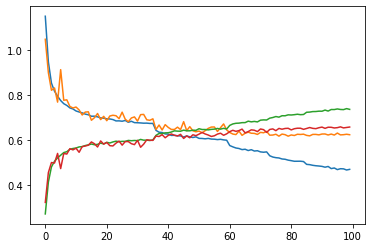

In [27]:
import pickle
pickle.dump(hist, open('./feature_act_5_tripletloss_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [26]:
model = torch.load('./feature_act_5_tripletloss_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, embeddings = model(inputs)
    indices_tuple = mining_func(embeddings, labels)
    triplet_loss = loss_func(embeddings, labels, indices_tuple)
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    all_loss = (0.6*loss) + (0.4*triplet_loss)

    running_valloss += (all_loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.603 | Avg. val_acc: 0.668


### Residual Feature Act 5

In [12]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))

        # pool to fix H and W size
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
        src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_feature * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        target_x = target_x * (1 + cor_feature)

        return target_x

In [16]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 32)
        self.fact1 = FeatureAct(64, 64)
        self.fact2 = FeatureAct(128, 128)
        self.fact3 = FeatureAct(256, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x0a = self.relu(x)
        
        x = self.conv0b(x0a)
        x = self.bn0b(x)
        x0b = self.relu(x)

        xfact0 = self.fact0(x0a, x0b)
        x = self.maxpool(xfact0)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x1a = self.relu(x)
        
        x = self.conv1b(x1a)
        x = self.bn1b(x)
        x1b = self.relu(x)
        
        xfact1 = self.fact1(x1a, x1b)
        x = self.maxpool(xfact1)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x2a = self.relu(x)
        
        x = self.conv2b(x2a)
        x = self.bn2b(x)
        x2b = self.relu(x)
        
        xfact2 = self.fact2(x2a, x2b)
        x = self.maxpool(xfact2)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x3a = self.relu(x)
        
        x = self.conv3b(x3a)
        x = self.bn3b(x)
        x3b = self.relu(x)
        
        xfact3 = self.fact3(x3a, x3b)
        
        x = self.maxpool(xfact3)
        
        
        x_emb = nn.Flatten()(x)
        x = self.classifier(x_emb)
        
        return x, x_emb

In [17]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [18]:
model_path = './residual_feature_act_5_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.090327501296997 cep_loss=1.7432479858398438 triplet_loss=0.11094668507575989 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 1.182 | Avg.acc: 0.253



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.266
* Update optimal model
Epoch:  2


Loss=0.9414949417114258 cep_loss=1.4996082782745361 triplet_loss=0.1043248400092125 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 1.025 | Avg.acc: 0.352



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.335
* Update optimal model
Epoch:  3


Loss=0.9455903172492981 cep_loss=1.504421353340149 triplet_loss=0.10734370350837708 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.894 | Avg.acc: 0.449



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.884 | Avg. val_acc: 0.474
* Update optimal model
Epoch:  4


Loss=0.8946765065193176 cep_loss=1.4230018854141235 triplet_loss=0.10218823701143265 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.838 | Avg.acc: 0.490



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.407
Epoch:  5


Loss=0.9946898818016052 cep_loss=1.5889512300491333 triplet_loss=0.10329776257276535 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.812 | Avg.acc: 0.505



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.804 | Avg. val_acc: 0.510
* Update optimal model
Epoch:  6


Loss=0.927017331123352 cep_loss=1.4759509563446045 triplet_loss=0.10361691564321518 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.790 | Avg.acc: 0.524



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.813 | Avg. val_acc: 0.509
Epoch:  7


Loss=0.7644625306129456 cep_loss=1.2056834697723389 triplet_loss=0.10263103246688843 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.775 | Avg.acc: 0.535



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.781 | Avg. val_acc: 0.532
* Update optimal model
Epoch:  8


Loss=0.845079779624939 cep_loss=1.3382700681686401 triplet_loss=0.10529429465532303 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.761 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.747 | Avg. val_acc: 0.549
* Update optimal model
Epoch:  9


Loss=0.8243651390075684 cep_loss=1.3019403219223022 triplet_loss=0.10800234973430634 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.753 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.742 | Avg. val_acc: 0.571
* Update optimal model
Epoch:  10


Loss=0.7486582398414612 cep_loss=1.182356357574463 triplet_loss=0.09811107069253922 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.742 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.735 | Avg. val_acc: 0.573
* Update optimal model
Epoch:  11


Loss=0.7331252694129944 cep_loss=1.1553796529769897 triplet_loss=0.0997435674071312 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.734 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.737 | Avg. val_acc: 0.550
Epoch:  12


Loss=0.7878993153572083 cep_loss=1.2458592653274536 triplet_loss=0.10095939040184021 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.730 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.726 | Avg. val_acc: 0.557
Epoch:  13


Loss=0.6694838404655457 cep_loss=1.0531320571899414 triplet_loss=0.09401141852140427 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.725 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.712 | Avg. val_acc: 0.571
Epoch:  14


Loss=0.8645131587982178 cep_loss=1.37172269821167 triplet_loss=0.10369886457920074 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.718 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.717 | Avg. val_acc: 0.579
* Update optimal model
Epoch:  15


Loss=0.6807230710983276 cep_loss=1.0747466087341309 triplet_loss=0.0896877720952034 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.717 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.720 | Avg. val_acc: 0.566
Epoch:  16


Loss=0.6605008840560913 cep_loss=1.0320698022842407 triplet_loss=0.1031474843621254 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.712 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.720 | Avg. val_acc: 0.574
Epoch:  17


Loss=0.563755452632904 cep_loss=0.877007782459259 triplet_loss=0.09387688338756561 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.706 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.718 | Avg. val_acc: 0.578
Epoch:  18


Loss=0.8001537322998047 cep_loss=1.2629250288009644 triplet_loss=0.10599678754806519 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.704 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.720 | Avg. val_acc: 0.578
Epoch:  19


Loss=0.8319283723831177 cep_loss=1.320243239402771 triplet_loss=0.0994560569524765 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [02:11<00:00,  1.70it/s]

- Avg.loss: 0.701 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.718 | Avg. val_acc: 0.584
* Update optimal model
Epoch:  20


Loss=0.6807431578636169 cep_loss=1.0719448328018188 triplet_loss=0.09394057840108871 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.700 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.713 | Avg. val_acc: 0.580
Epoch:  21


Loss=0.666270911693573 cep_loss=1.0452221632003784 triplet_loss=0.0978439450263977 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.697 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.755 | Avg. val_acc: 0.557
Epoch    21: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  22


Loss=0.6837378740310669 cep_loss=1.0724644660949707 triplet_loss=0.10064791887998581 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.661 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.660 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  23


Loss=0.4974685311317444 cep_loss=0.7668565511703491 triplet_loss=0.09338643401861191 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.651 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.664 | Avg. val_acc: 0.609
Epoch:  24


Loss=0.6786741614341736 cep_loss=1.0624643564224243 triplet_loss=0.10298880189657211 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.654 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.657 | Avg. val_acc: 0.620
* Update optimal model
Epoch:  25


Loss=0.640181303024292 cep_loss=1.0028512477874756 triplet_loss=0.09617628157138824 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.645 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.660 | Avg. val_acc: 0.608
Epoch:  26


Loss=0.5242137908935547 cep_loss=0.8060022592544556 triplet_loss=0.10153111070394516 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.641 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.680 | Avg. val_acc: 0.595
Epoch:  27


Loss=0.7140130996704102 cep_loss=1.1244421005249023 triplet_loss=0.09836963564157486 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.641 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.660 | Avg. val_acc: 0.618
Epoch:  28


Loss=0.9461584687232971 cep_loss=1.5095444917678833 triplet_loss=0.1010792925953865 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.638 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.648 | Avg. val_acc: 0.624
* Update optimal model
Epoch:  29


Loss=0.5821099877357483 cep_loss=0.9131722450256348 triplet_loss=0.085516557097435 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.632 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.673 | Avg. val_acc: 0.605
Epoch:  30


Loss=0.7070444226264954 cep_loss=1.114051342010498 triplet_loss=0.09653403609991074 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.632 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.660 | Avg. val_acc: 0.605
Epoch:  31


Loss=0.7137925624847412 cep_loss=1.119711995124817 triplet_loss=0.10491346567869186 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.630 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.659 | Avg. val_acc: 0.607
Epoch:  32


Loss=0.7981500625610352 cep_loss=1.260755181312561 triplet_loss=0.10424227267503738 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.625 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.654 | Avg. val_acc: 0.619
Epoch:  33


Loss=0.609542727470398 cep_loss=0.9431549310684204 triplet_loss=0.10912434756755829 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.620 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.662 | Avg. val_acc: 0.612
Epoch:  34


Loss=0.47544434666633606 cep_loss=0.7269498705863953 triplet_loss=0.09818598628044128 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.623 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.646 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  35


Loss=0.6667333245277405 cep_loss=1.0433992147445679 triplet_loss=0.10173437744379044 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.618 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.661 | Avg. val_acc: 0.614
Epoch:  36


Loss=0.6375728249549866 cep_loss=0.9873671531677246 triplet_loss=0.11288125067949295 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.619 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.645 | Avg. val_acc: 0.623
Epoch:  37


Loss=0.6565956473350525 cep_loss=1.025009036064148 triplet_loss=0.10397558659315109 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.614 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.675 | Avg. val_acc: 0.618
Epoch:  38


Loss=0.5101289749145508 cep_loss=0.791146993637085 triplet_loss=0.08860195428133011 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.612 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.667 | Avg. val_acc: 0.612
Epoch:  39


Loss=0.7055870890617371 cep_loss=1.1059918403625488 triplet_loss=0.10497990250587463 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.611 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.666 | Avg. val_acc: 0.614
Epoch:  40


Loss=0.7098021507263184 cep_loss=1.1075702905654907 triplet_loss=0.11314991116523743 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.609 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.643 | Avg. val_acc: 0.619
Epoch:  41


Loss=0.7136817574501038 cep_loss=1.1231069564819336 triplet_loss=0.09954395145177841 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.608 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.658 | Avg. val_acc: 0.619
Epoch:  42


Loss=0.7329281568527222 cep_loss=1.1533108949661255 triplet_loss=0.10235392302274704 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.605 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.660 | Avg. val_acc: 0.607
Epoch:  43


Loss=0.5671535134315491 cep_loss=0.8821207284927368 triplet_loss=0.09470275044441223 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.609 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.643 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  44


Loss=0.5558046102523804 cep_loss=0.8643808364868164 triplet_loss=0.09294021874666214 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.605 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.660 | Avg. val_acc: 0.621
Epoch:  45


Loss=0.7391348481178284 cep_loss=1.1664210557937622 triplet_loss=0.09820551425218582 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.602 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.633
* Update optimal model
Epoch:  46


Loss=0.45554083585739136 cep_loss=0.6936203837394714 triplet_loss=0.09842146933078766 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.602 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.644 | Avg. val_acc: 0.631
Epoch:  47


Loss=0.5818949341773987 cep_loss=0.9096990823745728 triplet_loss=0.09018869698047638 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.599 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.664 | Avg. val_acc: 0.611
Epoch:  48


Loss=0.6194533109664917 cep_loss=0.9659999012947083 triplet_loss=0.09963329136371613 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.599 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.659 | Avg. val_acc: 0.624
Epoch:  49


Loss=0.724368155002594 cep_loss=1.144118070602417 triplet_loss=0.09474322944879532 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.597 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.665 | Avg. val_acc: 0.613
Epoch:  50


Loss=0.721673846244812 cep_loss=1.136348009109497 triplet_loss=0.09966246783733368 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [02:11<00:00,  1.70it/s]

- Avg.loss: 0.594 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.675 | Avg. val_acc: 0.610
Epoch:  51


Loss=0.5632328987121582 cep_loss=0.87339186668396 triplet_loss=0.09799439460039139 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.594 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.643 | Avg. val_acc: 0.622
Epoch:  52


Loss=0.4647338390350342 cep_loss=0.7082422375679016 triplet_loss=0.09947118908166885 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.592 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.642 | Avg. val_acc: 0.629
Epoch:  53


Loss=0.761014461517334 cep_loss=1.2059425115585327 triplet_loss=0.09362228214740753 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [02:13<00:00,  1.69it/s]

- Avg.loss: 0.593 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.639 | Avg. val_acc: 0.635
Epoch    53: reducing learning rate of group 0 to 1.0000e-03.
* Update optimal model
Epoch:  54


Loss=0.5949001312255859 cep_loss=0.9229443669319153 triplet_loss=0.10283367335796356 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.566 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.637 | Avg. val_acc: 0.632
Epoch:  55


Loss=0.654525876045227 cep_loss=1.015974521636963 triplet_loss=0.11235275119543076 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.558 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.638
* Update optimal model
Epoch:  56


Loss=0.6675859093666077 cep_loss=1.0466029644012451 triplet_loss=0.09906017780303955 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:14<00:00,  1.68it/s]

- Avg.loss: 0.551 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.624 | Avg. val_acc: 0.646
* Update optimal model
Epoch:  57


Loss=0.5556382536888123 cep_loss=0.8614104986190796 triplet_loss=0.09697984904050827 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:38<00:00,  1.24s/it]

- Avg.loss: 0.544 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.629 | Avg. val_acc: 0.643
Epoch:  58


Loss=0.5766133069992065 cep_loss=0.8958261013031006 triplet_loss=0.09779410064220428 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [05:33<00:00,  1.48s/it]

- Avg.loss: 0.548 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.633 | Avg. val_acc: 0.638
Epoch:  59


Loss=0.45500582456588745 cep_loss=0.6977522373199463 triplet_loss=0.09088616818189621 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [04:27<00:00,  1.19s/it]

- Avg.loss: 0.542 | Avg.acc: 0.689



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.634 | Avg. val_acc: 0.636
Epoch:  60


Loss=0.4977540671825409 cep_loss=0.7658636569976807 triplet_loss=0.09558958560228348 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [05:30<00:00,  1.47s/it]

- Avg.loss: 0.546 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.621 | Avg. val_acc: 0.644
Epoch:  61


Loss=0.5993853211402893 cep_loss=0.9293184876441956 triplet_loss=0.10448548197746277 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [05:31<00:00,  1.47s/it]

- Avg.loss: 0.538 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.630 | Avg. val_acc: 0.635
Epoch:  62


Loss=0.45684629678726196 cep_loss=0.6953493356704712 triplet_loss=0.09909169375896454 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [05:31<00:00,  1.47s/it]

- Avg.loss: 0.538 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.656 | Avg. val_acc: 0.628
Epoch:  63


Loss=0.4337114095687866 cep_loss=0.660327672958374 triplet_loss=0.09378696233034134 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [05:32<00:00,  1.48s/it]

- Avg.loss: 0.534 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.631 | Avg. val_acc: 0.638
Epoch:  64


Loss=0.5439723134040833 cep_loss=0.8462095260620117 triplet_loss=0.09061648696660995 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:51<00:00,  1.31it/s]

- Avg.loss: 0.532 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.636 | Avg. val_acc: 0.639
Epoch:  65


Loss=0.6255916357040405 cep_loss=0.9797286987304688 triplet_loss=0.09438599646091461 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.531 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.628 | Avg. val_acc: 0.645
Epoch:  66


Loss=0.6152347922325134 cep_loss=0.9625925421714783 triplet_loss=0.09419818222522736 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.528 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.636
Epoch:  67


Loss=0.6794937252998352 cep_loss=1.0618592500686646 triplet_loss=0.10594526678323746 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.528 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.636 | Avg. val_acc: 0.642
Epoch:  68


Loss=0.4838079810142517 cep_loss=0.7387250661849976 triplet_loss=0.10143227130174637 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.526 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.646
Epoch    68: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  69


Loss=0.4793251156806946 cep_loss=0.7367188334465027 triplet_loss=0.09323444217443466 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.506 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.644
Epoch:  70


Loss=0.4177660346031189 cep_loss=0.6323533058166504 triplet_loss=0.09588508307933807 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.501 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.628 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  71


Loss=0.4728584289550781 cep_loss=0.7260469198226929 triplet_loss=0.09307566285133362 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:13<00:00,  1.69it/s]

- Avg.loss: 0.494 | Avg.acc: 0.722



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.627 | Avg. val_acc: 0.648
Epoch:  72


Loss=0.5202565789222717 cep_loss=0.7920022010803223 triplet_loss=0.11263806372880936 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.490 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.650
* Update optimal model
Epoch:  73


Loss=0.5801094770431519 cep_loss=0.8939832448959351 triplet_loss=0.10929886251688004 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.492 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.624 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  74


Loss=0.48622703552246094 cep_loss=0.7465943098068237 triplet_loss=0.09567614644765854 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:12<00:00,  1.69it/s]

- Avg.loss: 0.487 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.649
Epoch:  75


Loss=0.5171905755996704 cep_loss=0.7993650436401367 triplet_loss=0.09392882138490677 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:13<00:00,  1.68it/s]

- Avg.loss: 0.484 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.635 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  76


Loss=0.3666185438632965 cep_loss=0.5525679588317871 triplet_loss=0.08769439160823822 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [02:14<00:00,  1.68it/s]

- Avg.loss: 0.481 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.629 | Avg. val_acc: 0.651
Epoch    76: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  77


Loss=0.3971191644668579 cep_loss=0.596574068069458 triplet_loss=0.09793680161237717 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [02:14<00:00,  1.68it/s]

- Avg.loss: 0.472 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.625 | Avg. val_acc: 0.653
Epoch:  78


Loss=0.3657401502132416 cep_loss=0.5488178133964539 triplet_loss=0.09112365543842316 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:13<00:00,  1.68it/s]

- Avg.loss: 0.465 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.631 | Avg. val_acc: 0.651
Epoch:  79


Loss=0.6402378678321838 cep_loss=0.9886873364448547 triplet_loss=0.1175636351108551 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.463 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.659
* Update optimal model
Epoch:  80


Loss=0.45888403058052063 cep_loss=0.7009980082511902 triplet_loss=0.09571297466754913 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:11<00:00,  1.70it/s]

- Avg.loss: 0.461 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.637 | Avg. val_acc: 0.649
Epoch:  81


Loss=0.4288560152053833 cep_loss=0.6505085825920105 triplet_loss=0.09637711197137833 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.459 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.631 | Avg. val_acc: 0.657
Epoch:  82


Loss=0.5648540258407593 cep_loss=0.8704724907875061 triplet_loss=0.10642625391483307 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.457 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.635 | Avg. val_acc: 0.651
Epoch:  83


Loss=0.34307169914245605 cep_loss=0.5117398500442505 triplet_loss=0.0900694876909256 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.455 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.636 | Avg. val_acc: 0.654
Epoch:  84


Loss=0.6419591307640076 cep_loss=1.0071676969528198 triplet_loss=0.0941462442278862 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.454 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.640 | Avg. val_acc: 0.654
Epoch    84: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  85


Loss=0.5573780536651611 cep_loss=0.8633148670196533 triplet_loss=0.09847290813922882 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.441 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.655
Epoch:  86


Loss=0.43868982791900635 cep_loss=0.6679567694664001 triplet_loss=0.09478934854269028 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:13<00:00,  1.68it/s]

- Avg.loss: 0.446 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.636 | Avg. val_acc: 0.656
Epoch:  87


Loss=0.5462816953659058 cep_loss=0.844989001750946 triplet_loss=0.09822072833776474 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:14<00:00,  1.68it/s]

- Avg.loss: 0.440 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.654
Epoch:  88


Loss=0.29753535985946655 cep_loss=0.436778724193573 triplet_loss=0.08867023885250092 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [02:13<00:00,  1.69it/s]

- Avg.loss: 0.439 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.637 | Avg. val_acc: 0.650
Epoch:  89


Loss=0.4046475291252136 cep_loss=0.6172047257423401 triplet_loss=0.08581169694662094 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [02:12<00:00,  1.69it/s]

- Avg.loss: 0.441 | Avg.acc: 0.753



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.654
Epoch:  90


Loss=0.4090743362903595 cep_loss=0.6204429864883423 triplet_loss=0.09202130138874054 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.434 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.656
Epoch:  91


Loss=0.43752723932266235 cep_loss=0.6679534316062927 triplet_loss=0.09188792109489441 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.433 | Avg.acc: 0.761



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.640 | Avg. val_acc: 0.652
Epoch:  92


Loss=0.46311497688293457 cep_loss=0.7049567103385925 triplet_loss=0.10035233944654465 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.434 | Avg.acc: 0.761



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.655
Epoch    92: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  93


Loss=0.2839401662349701 cep_loss=0.4195196330547333 triplet_loss=0.08057096600532532 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.432 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.653
Epoch:  94


Loss=0.5824175477027893 cep_loss=0.9019201993942261 triplet_loss=0.10316362977027893 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.430 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.655
Epoch:  95


Loss=0.6389833688735962 cep_loss=0.9836389422416687 triplet_loss=0.12199999392032623 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.429 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.642 | Avg. val_acc: 0.653
Epoch:  96


Loss=0.49420270323753357 cep_loss=0.7558034658432007 triplet_loss=0.10180153697729111 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.428 | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.645 | Avg. val_acc: 0.656
Epoch:  97


Loss=0.5744361877441406 cep_loss=0.8961906433105469 triplet_loss=0.09180445969104767 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]

- Avg.loss: 0.429 | Avg.acc: 0.764



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.644 | Avg. val_acc: 0.656
Epoch:  98


Loss=0.48039063811302185 cep_loss=0.740973174571991 triplet_loss=0.08951681852340698 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.429 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.643 | Avg. val_acc: 0.652
Epoch:  99


Loss=0.4152766466140747 cep_loss=0.6323602795600891 triplet_loss=0.08965109288692474 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.427 | Avg.acc: 0.767



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.647 | Avg. val_acc: 0.654
Epoch:  100


Loss=0.4939425587654114 cep_loss=0.7534729242324829 triplet_loss=0.10464701056480408 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [02:12<00:00,  1.70it/s]

- Avg.loss: 0.426 | Avg.acc: 0.764


- Avg. val_loss: 0.646 | Avg. val_acc: 0.651
Epoch   100: reducing learning rate of group 0 to 3.1250e-05.
Finished Training


In [19]:
import pickle
pickle.dump(hist, open('residual_feature_act_5_tripletloss_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7efb907f8978>,
 0.6592365561437726)

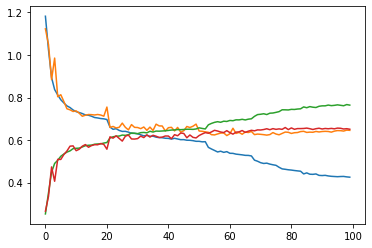

In [20]:
plt.plot(hist), best_acc

In [21]:
model = torch.load('residual_feature_act_5_tripletloss_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, embeddings = model(inputs)
    indices_tuple = mining_func(embeddings, labels)
    triplet_loss = loss_func(embeddings, labels, indices_tuple)
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    all_loss = (0.6*loss) + (0.4*triplet_loss)

    running_valloss += (all_loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.624 | Avg. val_acc: 0.662


### Feature Act 6 with triplet loss for last conv feature and cor feature

In [6]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
        src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_feature * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)

        target_x = target_x * (1 + cor_feature)

        return target_x, nn.Flatten()(cor_feature)

In [15]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1, cf0 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2, cf1 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3, cf2 = self.fact2_3(x2, x3)
        
        x_classifier = nn.Flatten()(xfact2_3)
        x_emb = torch.cat([x_classifier, cf0, cf1, cf2], dim=1)
        x = self.classifier(x_classifier)
        
        return x, x_emb

In [16]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [17]:
model_path = './feature_act_6_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=0.9832972884178162 cep_loss=1.5703586339950562 triplet_loss=0.10270519554615021 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 1.102 | Avg.acc: 0.300



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.201 | Avg. val_acc: 0.312
* Update optimal model
Epoch:  2


Loss=0.8579105138778687 cep_loss=1.3610385656356812 triplet_loss=0.10321839153766632 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.916 | Avg.acc: 0.438



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.848 | Avg. val_acc: 0.480
* Update optimal model
Epoch:  3


Loss=0.6923818588256836 cep_loss=1.0900413990020752 triplet_loss=0.09589255601167679 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.846 | Avg.acc: 0.483



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.798 | Avg. val_acc: 0.525
* Update optimal model
Epoch:  4


Loss=0.8672512769699097 cep_loss=1.3729838132858276 triplet_loss=0.10865248739719391 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.809 | Avg.acc: 0.512



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.874 | Avg. val_acc: 0.485
Epoch:  5


Loss=0.7950472235679626 cep_loss=1.2575063705444336 triplet_loss=0.10135845839977264 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.786 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.759 | Avg. val_acc: 0.543
* Update optimal model
Epoch:  6


Loss=0.5883482098579407 cep_loss=0.9152398109436035 triplet_loss=0.09801081568002701 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.769 | Avg.acc: 0.538



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.765 | Avg. val_acc: 0.548
* Update optimal model
Epoch:  7


Loss=0.6356600522994995 cep_loss=0.994905412197113 triplet_loss=0.09679203480482101 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.759 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.758 | Avg. val_acc: 0.549
* Update optimal model
Epoch:  8


Loss=0.6965867280960083 cep_loss=1.0933525562286377 triplet_loss=0.10143780708312988 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.752 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.777 | Avg. val_acc: 0.529
Epoch:  9


Loss=0.6897836327552795 cep_loss=1.077162504196167 triplet_loss=0.10871526598930359 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.740 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.807 | Avg. val_acc: 0.508
Epoch:  10


Loss=0.7091380953788757 cep_loss=1.1139332056045532 triplet_loss=0.10194539278745651 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.732 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.737 | Avg. val_acc: 0.564
* Update optimal model
Epoch:  11


Loss=0.8204386830329895 cep_loss=1.299818754196167 triplet_loss=0.10136844217777252 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.728 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.749 | Avg. val_acc: 0.554
Epoch:  12


Loss=0.913725733757019 cep_loss=1.456511378288269 triplet_loss=0.09954726696014404 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.727 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.721 | Avg. val_acc: 0.581
* Update optimal model
Epoch:  13


Loss=0.7662690877914429 cep_loss=1.2106422185897827 triplet_loss=0.09970934689044952 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.719 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.725 | Avg. val_acc: 0.578
Epoch:  14


Loss=0.6699544787406921 cep_loss=1.045264482498169 triplet_loss=0.10698942840099335 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.714 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.715 | Avg. val_acc: 0.572
Epoch:  15


Loss=0.7188510298728943 cep_loss=1.1333134174346924 triplet_loss=0.09715742617845535 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:21<00:00,  2.76it/s]

- Avg.loss: 0.712 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.731 | Avg. val_acc: 0.572
Epoch:  16


Loss=0.7624459862709045 cep_loss=1.2059489488601685 triplet_loss=0.09719152748584747 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.709 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.711 | Avg. val_acc: 0.576
Epoch:  17


Loss=0.9184753894805908 cep_loss=1.4630732536315918 triplet_loss=0.10157857090234756 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.704 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.698 | Avg. val_acc: 0.587
* Update optimal model
Epoch:  18


Loss=0.866292417049408 cep_loss=1.3740307092666626 triplet_loss=0.10468483716249466 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.703 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.698 | Avg. val_acc: 0.579
Epoch:  19


Loss=0.8771769404411316 cep_loss=1.3911628723144531 triplet_loss=0.10619785636663437 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.698 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.724 | Avg. val_acc: 0.559
Epoch:  20


Loss=0.6375066041946411 cep_loss=0.9993215799331665 triplet_loss=0.09478412568569183 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.696 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.708 | Avg. val_acc: 0.587
Epoch:  21


Loss=0.6267585754394531 cep_loss=0.9760240912437439 triplet_loss=0.10286013782024384 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.694 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.726 | Avg. val_acc: 0.574
Epoch:  22


Loss=0.589635968208313 cep_loss=0.9154408574104309 triplet_loss=0.10092848539352417 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.692 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.686 | Avg. val_acc: 0.603
* Update optimal model
Epoch:  23


Loss=0.6455939412117004 cep_loss=1.0063152313232422 triplet_loss=0.1045120432972908 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.691 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.696 | Avg. val_acc: 0.589
Epoch:  24


Loss=0.8295386433601379 cep_loss=1.3180583715438843 triplet_loss=0.09675884991884232 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.687 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.683 | Avg. val_acc: 0.598
Epoch:  25


Loss=0.6863545179367065 cep_loss=1.0768426656723022 triplet_loss=0.10062219947576523 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.687 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.702 | Avg. val_acc: 0.590
Epoch:  26


Loss=0.7383059859275818 cep_loss=1.1570467948913574 triplet_loss=0.11019464582204819 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.682 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.694 | Avg. val_acc: 0.588
Epoch:  27


Loss=0.7316944003105164 cep_loss=1.1475467681884766 triplet_loss=0.10791583359241486 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.684 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.724 | Avg. val_acc: 0.571
Epoch:  28


Loss=0.7534590363502502 cep_loss=1.1899323463439941 triplet_loss=0.09874898940324783 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.682 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.711 | Avg. val_acc: 0.580
Epoch:  29


Loss=1.0064678192138672 cep_loss=1.6100939512252808 triplet_loss=0.10102850943803787 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.682 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.708 | Avg. val_acc: 0.576
Epoch:  30


Loss=0.6385144591331482 cep_loss=0.9993770718574524 triplet_loss=0.09722047299146652 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.677 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.695 | Avg. val_acc: 0.594
Epoch:  31


Loss=0.691557765007019 cep_loss=1.0847686529159546 triplet_loss=0.10174137353897095 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.677 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.691 | Avg. val_acc: 0.593
Epoch:  32


Loss=0.7528098225593567 cep_loss=1.1874440908432007 triplet_loss=0.1008584201335907 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.676 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.689 | Avg. val_acc: 0.595
Epoch    32: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  33


Loss=0.6871896386146545 cep_loss=1.078481674194336 triplet_loss=0.10025153309106827 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.644 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.654 | Avg. val_acc: 0.610
* Update optimal model
Epoch:  34


Loss=0.6658440828323364 cep_loss=1.0433286428451538 triplet_loss=0.09961731731891632 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.636 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.672 | Avg. val_acc: 0.606
Epoch:  35


Loss=0.6457411050796509 cep_loss=1.010891318321228 triplet_loss=0.09801571071147919 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.635 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.662 | Avg. val_acc: 0.618
* Update optimal model
Epoch:  36


Loss=0.649127721786499 cep_loss=1.0163077116012573 triplet_loss=0.0983576700091362 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.631 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.640 | Avg. val_acc: 0.616
Epoch:  37


Loss=0.9586675763130188 cep_loss=1.526625394821167 triplet_loss=0.10673077404499054 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.624 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.656 | Avg. val_acc: 0.608
Epoch:  38


Loss=0.760149359703064 cep_loss=1.2027320861816406 triplet_loss=0.0962752252817154 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.625 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.653 | Avg. val_acc: 0.610
Epoch:  39


Loss=0.6574901938438416 cep_loss=1.028177261352539 triplet_loss=0.10145944356918335 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.625 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.657 | Avg. val_acc: 0.618
Epoch:  40


Loss=0.5971788167953491 cep_loss=0.9230288863182068 triplet_loss=0.108403779566288 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.622 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.644 | Avg. val_acc: 0.621
* Update optimal model
Epoch:  41


Loss=0.5898117423057556 cep_loss=0.9178135991096497 triplet_loss=0.09780881553888321 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.616 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.637 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  42


Loss=0.5434410572052002 cep_loss=0.8445211052894592 triplet_loss=0.09182090312242508 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.615 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.652 | Avg. val_acc: 0.624
Epoch:  43


Loss=0.6771581768989563 cep_loss=1.056591510772705 triplet_loss=0.10800812393426895 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.616 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.660 | Avg. val_acc: 0.608
Epoch:  44


Loss=0.71048504114151 cep_loss=1.1143138408660889 triplet_loss=0.10474168509244919 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.613 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.648 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  45


Loss=0.5927751064300537 cep_loss=0.9200312495231628 triplet_loss=0.10189081728458405 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.612 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.667 | Avg. val_acc: 0.614
Epoch:  46


Loss=0.5520315170288086 cep_loss=0.8530594110488892 triplet_loss=0.1004895493388176 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.610 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.654 | Avg. val_acc: 0.624
Epoch:  47


Loss=0.7121357321739197 cep_loss=1.1196635961532593 triplet_loss=0.10084394365549088 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.606 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.667 | Avg. val_acc: 0.609
Epoch:  48


Loss=0.6984893679618835 cep_loss=1.0960757732391357 triplet_loss=0.10210980474948883 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.606 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.646 | Avg. val_acc: 0.620
Epoch:  49


Loss=0.5947378873825073 cep_loss=0.9220613241195679 triplet_loss=0.10375262051820755 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.607 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.663 | Avg. val_acc: 0.616
Epoch    49: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  50


Loss=0.566119372844696 cep_loss=0.8787967562675476 triplet_loss=0.09710332751274109 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.584 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.636 | Avg. val_acc: 0.636
* Update optimal model
Epoch:  51


Loss=0.4507409334182739 cep_loss=0.6836203932762146 triplet_loss=0.10142173618078232 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.573 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.634
Epoch:  52


Loss=0.45568162202835083 cep_loss=0.697736918926239 triplet_loss=0.09259861707687378 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.571 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.639 | Avg. val_acc: 0.633
Epoch:  53


Loss=0.7740001678466797 cep_loss=1.215349793434143 triplet_loss=0.11197566241025925 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.568 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.629 | Avg. val_acc: 0.642
* Update optimal model
Epoch:  54


Loss=0.6964021921157837 cep_loss=1.0897482633590698 triplet_loss=0.10638304054737091 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.564 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.625 | Avg. val_acc: 0.644
* Update optimal model
Epoch:  55


Loss=0.7028419375419617 cep_loss=1.1006770133972168 triplet_loss=0.10608924925327301 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.562 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.638
Epoch:  56


Loss=0.5805896520614624 cep_loss=0.9038313627243042 triplet_loss=0.09572699666023254 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.562 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.647 | Avg. val_acc: 0.632
Epoch:  57


Loss=0.6151281595230103 cep_loss=0.9542081952095032 triplet_loss=0.10650794953107834 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.557 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.637 | Avg. val_acc: 0.635
Epoch:  58


Loss=0.6344273686408997 cep_loss=0.9950340986251831 triplet_loss=0.09351708739995956 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.554 | Avg.acc: 0.682



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.639 | Avg. val_acc: 0.634
Epoch:  59


Loss=0.6551743745803833 cep_loss=1.029026746749878 triplet_loss=0.0943957194685936 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.552 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.622 | Avg. val_acc: 0.644
Epoch:  60


Loss=0.5242465734481812 cep_loss=0.8122605085372925 triplet_loss=0.09222555160522461 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.552 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.633 | Avg. val_acc: 0.637
Epoch:  61


Loss=0.5246248245239258 cep_loss=0.811314582824707 triplet_loss=0.09459014236927032 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.551 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.624 | Avg. val_acc: 0.642
Epoch:  62


Loss=0.5346013903617859 cep_loss=0.8193809986114502 triplet_loss=0.10743189603090286 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.547 | Avg.acc: 0.686



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.623 | Avg. val_acc: 0.646
* Update optimal model
Epoch:  63


Loss=0.6801910996437073 cep_loss=1.072533369064331 triplet_loss=0.09167756140232086 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.545 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.646 | Avg. val_acc: 0.639
Epoch:  64


Loss=0.6457758545875549 cep_loss=1.0115435123443604 triplet_loss=0.09712426364421844 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.544 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.639 | Avg. val_acc: 0.638
Epoch:  65


Loss=0.3944607675075531 cep_loss=0.5922788977622986 triplet_loss=0.09773354232311249 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.542 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.635 | Avg. val_acc: 0.644
Epoch:  66


Loss=0.5420925617218018 cep_loss=0.8323771357536316 triplet_loss=0.10666567087173462 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.544 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.625 | Avg. val_acc: 0.646
Epoch:  67


Loss=0.547022819519043 cep_loss=0.8457328081130981 triplet_loss=0.09895774722099304 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.540 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.632 | Avg. val_acc: 0.640
Epoch    67: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  68


Loss=0.4679452180862427 cep_loss=0.7151371836662292 triplet_loss=0.09715723991394043 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.525 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.621 | Avg. val_acc: 0.640
Epoch:  69


Loss=0.41266176104545593 cep_loss=0.6264760494232178 triplet_loss=0.09194031357765198 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.516 | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.626 | Avg. val_acc: 0.646
Epoch:  70


Loss=0.5297640562057495 cep_loss=0.8162899613380432 triplet_loss=0.0999750941991806 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.513 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.628 | Avg. val_acc: 0.647
* Update optimal model
Epoch:  71


Loss=0.4903912842273712 cep_loss=0.7535260915756226 triplet_loss=0.09568902105093002 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.510 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.625 | Avg. val_acc: 0.647
Epoch:  72


Loss=0.43937522172927856 cep_loss=0.6707481741905212 triplet_loss=0.09231574833393097 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.509 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.619 | Avg. val_acc: 0.646
Epoch:  73


Loss=0.7902483940124512 cep_loss=1.2457606792449951 triplet_loss=0.10697997361421585 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.507 | Avg.acc: 0.711



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.627 | Avg. val_acc: 0.649
* Update optimal model
Epoch:  74


Loss=0.6143820285797119 cep_loss=0.9563775062561035 triplet_loss=0.10138871520757675 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.504 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.638
Epoch:  75


Loss=0.600548267364502 cep_loss=0.9344204068183899 triplet_loss=0.09973996877670288 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.506 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.628 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  76


Loss=0.4334565997123718 cep_loss=0.6521722674369812 triplet_loss=0.1053830236196518 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:20<00:00,  2.80it/s]

- Avg.loss: 0.501 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.630 | Avg. val_acc: 0.644
Epoch:  77


Loss=0.5306469202041626 cep_loss=0.8240848779678345 triplet_loss=0.0904899537563324 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.498 | Avg.acc: 0.715



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.632 | Avg. val_acc: 0.644
Epoch:  78


Loss=0.5261293053627014 cep_loss=0.8132476806640625 triplet_loss=0.095451720058918 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.497 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.633 | Avg. val_acc: 0.644
Epoch:  79


Loss=0.6094843149185181 cep_loss=0.955069363117218 triplet_loss=0.09110681712627411 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.495 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.628 | Avg. val_acc: 0.646
Epoch:  80


Loss=0.43736737966537476 cep_loss=0.6664388179779053 triplet_loss=0.0937601625919342 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.495 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.631 | Avg. val_acc: 0.646
Epoch    80: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  81


Loss=0.6799697279930115 cep_loss=1.0609995126724243 triplet_loss=0.10842495411634445 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.484 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.630 | Avg. val_acc: 0.646
Epoch:  82


Loss=0.42982497811317444 cep_loss=0.6529877185821533 triplet_loss=0.09508077800273895 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.479 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.632 | Avg. val_acc: 0.648
Epoch:  83


Loss=0.5483930110931396 cep_loss=0.850919783115387 triplet_loss=0.0946028009057045 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.479 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.629 | Avg. val_acc: 0.645
Epoch:  84


Loss=0.4701221287250519 cep_loss=0.712795078754425 triplet_loss=0.10611265152692795 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.473 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.630 | Avg. val_acc: 0.651
Epoch:  85


Loss=0.5839383006095886 cep_loss=0.9093709588050842 triplet_loss=0.095789335668087 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.473 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.632 | Avg. val_acc: 0.648
Epoch:  86


Loss=0.5716338157653809 cep_loss=0.8809709548950195 triplet_loss=0.10762817412614822 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.473 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.630 | Avg. val_acc: 0.647
Epoch:  87


Loss=0.6498199105262756 cep_loss=1.018728494644165 triplet_loss=0.09645701199769974 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.472 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.632 | Avg. val_acc: 0.649
Epoch:  88


Loss=0.38567492365837097 cep_loss=0.5836466550827026 triplet_loss=0.0887172669172287 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:21<00:00,  2.78it/s]

- Avg.loss: 0.471 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.629 | Avg. val_acc: 0.646
Epoch    88: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  89


Loss=0.4614628553390503 cep_loss=0.71197909116745 triplet_loss=0.08568841964006424 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.468 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.630 | Avg. val_acc: 0.650
Epoch:  90


Loss=0.5702051520347595 cep_loss=0.884351909160614 triplet_loss=0.09898500144481659 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.461 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.631 | Avg. val_acc: 0.646
Epoch:  91


Loss=0.5463424921035767 cep_loss=0.8517405390739441 triplet_loss=0.08824536204338074 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.459 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.634 | Avg. val_acc: 0.648
Epoch:  92


Loss=0.47569572925567627 cep_loss=0.734724223613739 triplet_loss=0.08715293556451797 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:20<00:00,  2.79it/s]

- Avg.loss: 0.460 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.635 | Avg. val_acc: 0.649
Epoch:  93


Loss=0.3644413650035858 cep_loss=0.5478580594062805 triplet_loss=0.08931627124547958 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.458 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.631 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  94


Loss=0.5457651019096375 cep_loss=0.8417587876319885 triplet_loss=0.10177447646856308 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.455 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.645
Epoch:  95


Loss=0.6195997595787048 cep_loss=0.9635223150253296 triplet_loss=0.10371576249599457 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:21<00:00,  2.77it/s]

- Avg.loss: 0.454 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.641 | Avg. val_acc: 0.648
Epoch:  96


Loss=0.47351518273353577 cep_loss=0.7265723943710327 triplet_loss=0.09392930567264557 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.455 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.638 | Avg. val_acc: 0.648
Epoch    96: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  97


Loss=0.36810699105262756 cep_loss=0.5410605669021606 triplet_loss=0.10867662727832794 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.452 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.637 | Avg. val_acc: 0.653
Epoch:  98


Loss=0.5637134909629822 cep_loss=0.876436710357666 triplet_loss=0.09462857991456985 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.454 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.635 | Avg. val_acc: 0.649
Epoch:  99


Loss=0.4466454088687897 cep_loss=0.6802904605865479 triplet_loss=0.09617777913808823 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.451 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.639 | Avg. val_acc: 0.653
Epoch:  100


Loss=0.3254254460334778 cep_loss=0.4857710897922516 triplet_loss=0.08490697294473648 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:20<00:00,  2.78it/s]

- Avg.loss: 0.449 | Avg.acc: 0.751


- Avg. val_loss: 0.637 | Avg. val_acc: 0.653
Finished Training


([<matplotlib.lines.Line2D at 0x7f8869ef14a8>,
 0.6542212315408191)

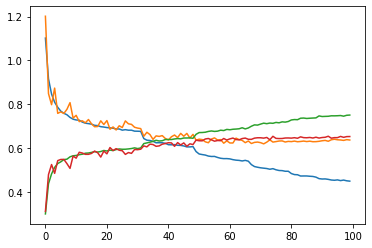

In [18]:
plt.plot(hist), best_acc

In [19]:
model = torch.load('./feature_act_6_tripletloss_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, embeddings = model(inputs)
    indices_tuple = mining_func(embeddings, labels)
    triplet_loss = loss_func(embeddings, labels, indices_tuple)
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    all_loss = (0.6*loss) + (0.4*triplet_loss)

    running_valloss += (all_loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.625 | Avg. val_acc: 0.654


### Feature Act 9

In [10]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.src_gap_ln = nn.Linear(src_feature, src_feature)
        self.target_gap_ln = nn.Linear(target_feature, target_feature)

        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        # self.sm = nn.Softmax(dim=1)

    def forward(self, src_x, target_x):
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)
        src_gap = self.src_gap_ln(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)
        target_gap = self.target_gap_ln(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        # sm_cor = self.sm(cor)
        sm_cor = cor / torch.norm(cor)

        # with torch.no_grad():
        #   sm_cor += torch.randn(sm_cor.size()).to(device)

        cor_feature = torch.cat([(src_x * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)
        cor_feature = self.relu(cor_feature)
        cor_feature = self.pool(cor_feature)

        # print('cor feature sigmoid: ', cor_feature)
        target_x = target_x * cor_feature

        return target_x, nn.Flatten()(sm_cor.permute(0,2,1))

In [11]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
            
            self.sub_classifier = nn.Sequential(nn.Linear(43008, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                                nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                                nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1, emb_0 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2, emb_1 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3, emb_2 = self.fact2_3(x2, x3)
        
        x_out = self.classifier(xfact2_3)
                
        x_sub = torch.cat([emb_0, emb_1, emb_2], dim=1)
        x_sub = self.sub_classifier(x_sub)
        
        return x_out, x_sub

In [12]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [ ]:
model_path = './feature_act_9_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sub_outs = model(inputs)
        
        loss = criterion(outputs, labels)
        sub_loss = criterion(sub_outs, labels)
        loss = (0.5*loss) + (0.5*sub_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        sub_acc = (torch.argmax(sub_outs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Sub_loss={sub_loss.item()} Loss={loss.item()} Batch_id={i} Sub_acc={sub_acc.item() / inputs.size(0)} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sub_outs = model(inputs)
        
        loss = criterion(outputs, labels)
        sub_loss = criterion(sub_outs, labels)
        loss = (0.5*loss) + (0.5*sub_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        sub_acc = (torch.argmax(sub_outs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Sub_loss=1.8308407068252563 Loss=1.9536583423614502 Batch_id=224 Sub_acc=0.24324324324324326 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [01:18<00:00,  2.85it/s]

- Avg.loss: 1.877 | Avg.acc: 0.252


- Avg. val_loss: 1.835 | Avg. val_acc: 0.251


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Sub_loss=1.6400357484817505 Loss=1.6159815788269043 Batch_id=224 Sub_acc=0.35135135135135137 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 1.776 | Avg.acc: 0.273


- Avg. val_loss: 1.811 | Avg. val_acc: 0.293


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Sub_loss=1.414980411529541 Loss=1.3612415790557861 Batch_id=224 Sub_acc=0.4594594594594595 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.580 | Avg.acc: 0.385


- Avg. val_loss: 1.802 | Avg. val_acc: 0.435


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Sub_loss=1.4510867595672607 Loss=1.4062378406524658 Batch_id=224 Sub_acc=0.3783783783783784 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.446 | Avg.acc: 0.448


- Avg. val_loss: 1.613 | Avg. val_acc: 0.438


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Sub_loss=1.3173519372940063 Loss=1.3112528324127197 Batch_id=224 Sub_acc=0.5675675675675675 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.370 | Avg.acc: 0.485


- Avg. val_loss: 1.648 | Avg. val_acc: 0.483


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Sub_loss=1.1806944608688354 Loss=1.1926243305206299 Batch_id=224 Sub_acc=0.5405405405405406 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.328 | Avg.acc: 0.502



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.511 | Avg. val_acc: 0.473
Epoch:  7


Sub_loss=1.5693233013153076 Loss=1.507997989654541 Batch_id=224 Sub_acc=0.4594594594594595 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.298 | Avg.acc: 0.509



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.608 | Avg. val_acc: 0.461
Epoch:  8


Sub_loss=1.0730655193328857 Loss=1.0319949388504028 Batch_id=224 Sub_acc=0.5675675675675675 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 1.269 | Avg.acc: 0.522


- Avg. val_loss: 1.416 | Avg. val_acc: 0.526


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Sub_loss=1.2120742797851562 Loss=1.2092944383621216 Batch_id=224 Sub_acc=0.6756756756756757 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.247 | Avg.acc: 0.528


- Avg. val_loss: 1.440 | Avg. val_acc: 0.535


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Sub_loss=1.1090619564056396 Loss=1.1086812019348145 Batch_id=224 Sub_acc=0.5405405405405406 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:19<00:00,  2.81it/s]

- Avg.loss: 1.233 | Avg.acc: 0.534


- Avg. val_loss: 1.279 | Avg. val_acc: 0.537


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Sub_loss=1.3737878799438477 Loss=1.3327314853668213 Batch_id=224 Sub_acc=0.4594594594594595 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 1.214 | Avg.acc: 0.542


- Avg. val_loss: 1.268 | Avg. val_acc: 0.555


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Sub_loss=1.1113865375518799 Loss=1.0954556465148926 Batch_id=224 Sub_acc=0.5405405405405406 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.205 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.482 | Avg. val_acc: 0.515
Epoch:  13


Sub_loss=1.576925277709961 Loss=1.5432943105697632 Batch_id=224 Sub_acc=0.5135135135135135 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.195 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.383 | Avg. val_acc: 0.515
Epoch:  14


Sub_loss=1.0623259544372559 Loss=1.0732316970825195 Batch_id=224 Sub_acc=0.5675675675675675 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.187 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.331 | Avg. val_acc: 0.543
Epoch:  15


Sub_loss=1.4318842887878418 Loss=1.4227303266525269 Batch_id=224 Sub_acc=0.35135135135135137 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.177 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.309 | Avg. val_acc: 0.534
Epoch:  16


Sub_loss=1.1412627696990967 Loss=1.1178315877914429 Batch_id=224 Sub_acc=0.5405405405405406 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 1.166 | Avg.acc: 0.560


- Avg. val_loss: 1.186 | Avg. val_acc: 0.563


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Sub_loss=1.2839525938034058 Loss=1.261927843093872 Batch_id=224 Sub_acc=0.5135135135135135 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 1.162 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.357 | Avg. val_acc: 0.536
Epoch:  18


Sub_loss=1.0786250829696655 Loss=1.0595462322235107 Batch_id=224 Sub_acc=0.5135135135135135 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:19<00:00,  2.81it/s]

- Avg.loss: 1.152 | Avg.acc: 0.566


- Avg. val_loss: 1.215 | Avg. val_acc: 0.570


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Sub_loss=1.0911056995391846 Loss=1.065926194190979 Batch_id=224 Sub_acc=0.5675675675675675 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 1.151 | Avg.acc: 0.565


- Avg. val_loss: 1.224 | Avg. val_acc: 0.574


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Sub_loss=1.2792881727218628 Loss=1.234443187713623 Batch_id=224 Sub_acc=0.5405405405405406 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.148 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.247 | Avg. val_acc: 0.543
Epoch:  21


Sub_loss=1.2325122356414795 Loss=1.2023926973342896 Batch_id=224 Sub_acc=0.4864864864864865 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.143 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.326 | Avg. val_acc: 0.561
Epoch:  22


Sub_loss=1.2582765817642212 Loss=1.2538604736328125 Batch_id=224 Sub_acc=0.43243243243243246 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 1.135 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214 | Avg. val_acc: 0.555
Epoch:  23


Sub_loss=1.1715542078018188 Loss=1.1334298849105835 Batch_id=224 Sub_acc=0.6216216216216216 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 1.131 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.231 | Avg. val_acc: 0.568
Epoch:  24


Sub_loss=1.20592200756073 Loss=1.238111972808838 Batch_id=224 Sub_acc=0.6216216216216216 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 1.130 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.330 | Avg. val_acc: 0.529
Epoch:  25


Sub_loss=0.9161369204521179 Loss=0.9072828888893127 Batch_id=70 Sub_acc=0.640625 Accuracy=0.6640625:  31%|███       | 70/225 [00:26<00:53,  2.89it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sub_loss=1.1242519617080688 Loss=1.1153150796890259 Batch_id=224 Sub_acc=0.6216216216216216 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:20<00:00,  2.81it/s]

- Avg.loss: 1.001 | Avg.acc: 0.627


- Avg. val_loss: 1.083 | Avg. val_acc: 0.606


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  44


Sub_loss=1.2021167278289795 Loss=1.1374775171279907 Batch_id=224 Sub_acc=0.5135135135135135 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 0.990 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.588
Epoch:  45


Sub_loss=1.2972208261489868 Loss=1.2740572690963745 Batch_id=224 Sub_acc=0.4864864864864865 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.987 | Avg.acc: 0.632


- Avg. val_loss: 1.088 | Avg. val_acc: 0.612


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  46


Sub_loss=0.9942407608032227 Loss=0.9737164378166199 Batch_id=224 Sub_acc=0.6486486486486487 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.982 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.603
Epoch:  47


Sub_loss=0.9768232107162476 Loss=0.9635996222496033 Batch_id=224 Sub_acc=0.6486486486486487 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.979 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.600
Epoch:  48


Sub_loss=1.0704548358917236 Loss=1.0467910766601562 Batch_id=224 Sub_acc=0.6216216216216216 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 0.976 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105 | Avg. val_acc: 0.610
Epoch:  49


Sub_loss=1.0676730871200562 Loss=1.0681636333465576 Batch_id=218 Sub_acc=0.5546875 Accuracy=0.546875:  97%|█████████▋| 219/225 [01:17<00:02,  2.99it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sub_loss=1.0267550945281982 Loss=1.0219314098358154 Batch_id=224 Sub_acc=0.5675675675675675 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.945 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.595
Epoch:  68


Sub_loss=1.2693778276443481 Loss=1.2750669717788696 Batch_id=224 Sub_acc=0.5675675675675675 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.945 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.596
Epoch:  69


Sub_loss=1.1590030193328857 Loss=1.1487541198730469 Batch_id=224 Sub_acc=0.5135135135135135 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.945 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.605
Epoch:  70


Sub_loss=1.0920326709747314 Loss=1.1064214706420898 Batch_id=224 Sub_acc=0.5675675675675675 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.941 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.595
Epoch    70: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  71


Sub_loss=1.4264895915985107 Loss=1.3867297172546387 Batch_id=224 Sub_acc=0.5675675675675675 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]

- Avg.loss: 0.926 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.606
Epoch:  72


Sub_loss=0.8651590347290039 Loss=0.8271841406822205 Batch_id=224 Sub_acc=0.6756756756756757 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:19<00:00,  2.82it/s]

- Avg.loss: 0.919 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.610
Epoch:  73


Sub_loss=0.9026660323143005 Loss=0.8662900924682617 Batch_id=187 Sub_acc=0.6953125 Accuracy=0.7109375:  83%|████████▎ | 187/225 [01:07<00:13,  2.86it/s]

([<matplotlib.lines.Line2D at 0x7f63791b7208>,
 0.6124268598495403)

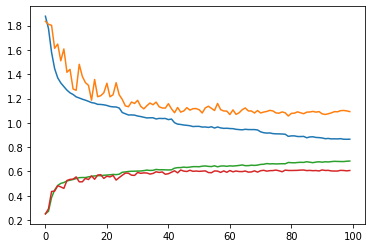

In [14]:
plt.plot(hist), best_acc

### Feature Act 10

In [6]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.src_gap_ln = nn.Linear(src_feature, src_feature)
        self.target_gap_ln = nn.Linear(target_feature, target_feature)

        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sm = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)
        src_gap = self.src_gap_ln(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)
        target_gap = self.target_gap_ln(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)
        sm_cor = self.sm(cor)

        # with torch.no_grad():
        #   sm_cor += torch.randn(sm_cor.size()).to(device)

        cor_feature = torch.cat([(src_x * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)
        cor_feature = self.pool(cor_feature)
        cor_feature = self.sigmoid(cor_feature)

        # print('cor feature sigmoid: ', cor_feature)
        target_x = target_x * cor_feature

        return target_x

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
            
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x_out = self.classifier(xfact2_3)
                
        return x_out

In [8]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [9]:
model_path = './feature_act_10_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.4631153345108032 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:13<00:00,  3.04it/s]

- Avg.loss: 1.603 | Avg.acc: 0.386



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.408 | Avg. val_acc: 0.469
* Update optimal model
Epoch:  2


Loss=1.4965957403182983 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.345 | Avg.acc: 0.487



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.414 | Avg. val_acc: 0.452
Epoch:  3


Loss=1.2363646030426025 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.272 | Avg.acc: 0.513



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.286 | Avg. val_acc: 0.518
* Update optimal model
Epoch:  4


Loss=1.37601637840271 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.233 | Avg.acc: 0.529



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.540
* Update optimal model
Epoch:  5


Loss=0.9715834856033325 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.202 | Avg.acc: 0.543



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.311 | Avg. val_acc: 0.513
Epoch:  6


Loss=1.02411687374115 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.01it/s]

- Avg.loss: 1.183 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.312 | Avg. val_acc: 0.522
Epoch:  7


Loss=1.4304800033569336 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.167 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.567
* Update optimal model
Epoch:  8


Loss=0.9679185152053833 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.150 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.562
Epoch:  9


Loss=1.0573205947875977 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.133 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.567
Epoch:  10


Loss=1.2188613414764404 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.127 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  11


Loss=1.170047402381897 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.115 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.586
* Update optimal model
Epoch:  12


Loss=1.2338767051696777 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.112 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.582
Epoch:  13


Loss=0.9190183281898499 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.107 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.570
Epoch:  14


Loss=0.9581936001777649 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.095 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.586
Epoch:  15


Loss=1.0543025732040405 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.086 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.585
Epoch:  16


Loss=1.1649531126022339 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.086 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.582
Epoch:  17


Loss=1.2613065242767334 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.081 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.122 | Avg. val_acc: 0.578
Epoch:  18


Loss=1.1625343561172485 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.078 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.586
Epoch:  19


Loss=0.9268594980239868 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.071 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.580
Epoch:  20


Loss=1.021140694618225 Batch_id=187 Accuracy=0.578125:  84%|████████▎ | 188/225 [01:02<00:11,  3.10it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.3019310235977173 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.016 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.585
Epoch:  37


Loss=0.7976472973823547 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.020 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.586
Epoch:  38


Loss=1.0314440727233887 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.018 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.593
Epoch:  39


Loss=1.507149577140808 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.019 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.605
Epoch:  40


Loss=0.7511909008026123 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.016 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.591
Epoch    40: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  41


Loss=0.9410606622695923 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:13<00:00,  3.04it/s]

- Avg.loss: 0.970 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  42


Loss=0.8992782831192017 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.950 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  43


Loss=0.9225732088088989 Batch_id=94 Accuracy=0.640625:  42%|████▏     | 95/225 [00:32<00:41,  3.10it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.1780855655670166 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.877 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.615
Epoch:  61


Loss=0.8927781581878662 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.881 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.620
Epoch:  62


Loss=0.9650542736053467 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 0.877 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.625
Epoch    62: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  63


Loss=1.0891997814178467 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:14<00:00,  3.01it/s]

- Avg.loss: 0.840 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.624
Epoch:  64


Loss=0.6596710681915283 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.816 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  65


Loss=0.569425106048584 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.814 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.625
Epoch:  66


Loss=0.9667026996612549 Batch_id=217 Accuracy=0.625:  97%|█████████▋| 218/225 [01:12<00:02,  3.24it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8218258619308472 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.682 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.640
Epoch:  85


Loss=0.6682588458061218 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.674 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.638
Epoch:  86


Loss=1.0166908502578735 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.677 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.637
Epoch:  87


Loss=0.6294503808021545 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.670 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.631
Epoch:  88


Loss=0.6058998107910156 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.660 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.632
Epoch:  89


Loss=0.5367361307144165 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.671 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.635
Epoch:  90


Loss=0.7354590892791748 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.659 | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.640
Epoch:  91


Loss=0.5812726616859436 Batch_id=116 Accuracy=0.828125:  52%|█████▏    | 117/225 [00:39<00:35,  3.08it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
import pickle
pickle.dump(hist, open('./feature_act_10_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7fef84815208>,
 0.6405684034550014)

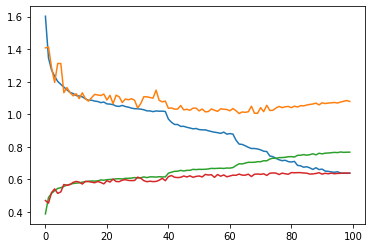

In [10]:
plt.plot(hist), best_acc

In [11]:
model = torch.load('./feature_act_10_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.027 | Avg. val_acc: 0.638


## Add triplet loss

In [7]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [11]:
model_path = './baseline_tripletloss.pt'
device = torch.device('cuda')
model=Baseline(embeddings=True)
model.to(device)

best_loss = 1e3
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [ ]:
for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
#     running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        
#         acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
#         running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}')

    print('- Avg.loss: %.3f' % (running_loss / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
#     avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
#     running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        

        running_valloss += (loss.item() * inputs.size(0))

    print('- Avg. val_loss: %.3f' % (running_valloss / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss])
    
    if best_loss > avgvalloss:
        best_loss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=0.1057901531457901 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s] 

- Avg.loss: 0.103



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.108
* Update optimal model
Epoch:  2


Loss=0.10689564794301987 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
* Update optimal model
Epoch:  3


Loss=0.1074071079492569 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s] 

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.108
Epoch:  4


Loss=0.10878229141235352 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.107
Epoch:  5


Loss=0.10899460315704346 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.105
Epoch:  6


Loss=0.10470321029424667 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
* Update optimal model
Epoch:  7


Loss=0.10832250118255615 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  8


Loss=0.10736994445323944 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.108
Epoch:  9


Loss=0.09777899831533432 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  10


Loss=0.1078610047698021 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s] 

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  11


Loss=0.09220985323190689 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  12


Loss=0.09583801031112671 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  13


Loss=0.10013246536254883 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  14


Loss=0.10031009465456009 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]


- Avg.loss: 0.102


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.105
Epoch:  15


Loss=0.10263319313526154 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch    15: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  16


Loss=0.1089475005865097 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s] 

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
* Update optimal model
Epoch:  17


Loss=0.1042950451374054 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s] 

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  18


Loss=0.09958044439554214 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  19


Loss=0.10087445378303528 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  20


Loss=0.10419227927923203 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  21


Loss=0.10668791830539703 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  22


Loss=0.10032140463590622 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  23


Loss=0.10548188537359238 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  24


Loss=0.10530705749988556 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  25


Loss=0.100258469581604 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]  

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch    25: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  26


Loss=0.10037489235401154 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  27


Loss=0.09672677516937256 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  28


Loss=0.09669945389032364 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  29


Loss=0.10422849655151367 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  30


Loss=0.1062685176730156 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s] 

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  31


Loss=0.10016380995512009 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  32


Loss=0.1026480495929718 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s] 

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  33


Loss=0.10064208507537842 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  34


Loss=0.10417351871728897 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  35


Loss=0.09510628134012222 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  36


Loss=0.09938575327396393 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  37


Loss=0.09779898077249527 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  38


Loss=0.10391625016927719 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  39


Loss=0.10146648436784744 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  40


Loss=0.09441796690225601 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  41


Loss=0.09773372858762741 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  42


Loss=0.10436741262674332 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  43


Loss=0.09665431082248688 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  44


Loss=0.0994633361697197 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s] 

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  45


Loss=0.10136669874191284 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  46


Loss=0.10161598026752472 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  47


Loss=0.0940605029463768 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s] 

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  48


Loss=0.10190575569868088 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  49


Loss=0.09605785459280014 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  50


Loss=0.09704715013504028 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  51


Loss=0.09650896489620209 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  52


Loss=0.09557102620601654 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  53


Loss=0.10023536533117294 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  54


Loss=0.09480453282594681 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  55


Loss=0.1020902544260025 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s] 

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  56


Loss=0.09515486657619476 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  57


Loss=0.10387720912694931 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  58


Loss=0.10092296451330185 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  59


Loss=0.10363693535327911 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  60


Loss=0.09852714836597443 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  61


Loss=0.09977546334266663 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch    61: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  62


Loss=0.10770120471715927 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  63


Loss=0.10616803914308548 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  64


Loss=0.08778837323188782 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  65


Loss=0.10094255208969116 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  66


Loss=0.08920393884181976 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  67


Loss=0.09462576359510422 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  68


Loss=0.11380410939455032 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  69


Loss=0.10583440214395523 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  70


Loss=0.09755150228738785 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  71


Loss=0.09997683763504028 Batch_id=23:  10%|█         | 23/225 [00:03<00:26,  7.49it/s]

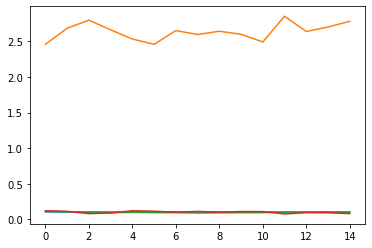

In [10]:
plt.plot(hist)